# 使用 RNN 预测电力变压器油温 / Power Transformer Oil Temperature Prediction using RNN

## 简介 / Introduction

本 notebook 实现了一个循环神经网络（RNN）模型来预测电力变压器的油温（OT）。

This notebook implements a Recurrent Neural Network (RNN) model for predicting the oil temperature (OT) of power transformers.

**数据集 / Dataset**: ETDataset (电力变压器温度数据集 / Electricity Transformer Temperature)
- 来源 / Source: https://github.com/zhouhaoyi/ETDataset
- 出处 / From: AAAI 2021 最佳论文（Informer 模型）/ AAAI 2021 Best Paper (Informer model)

**特征 / Features**:
- HUFL: 高压有功负载 / High UseFul Load
- HULL: 高压无功负载 / High UseLess Load  
- MUFL: 中压有功负载 / Medium UseFul Load
- MULL: 中压无功负载 / Medium UseLess Load
- LUFL: 低压有功负载 / Low UseFul Load
- LULL: 低压无功负载 / Low UseLess Load

**目标变量 / Target**: OT (油温 / Oil Temperature)

**目标 / Goal**: 基于历史负载数据构建 RNN 模型预测油温，并展示：
- 时间序列数据预处理 / Time series data preprocessing
- 用于序列预测的 RNN 架构 / RNN architecture for sequence prediction
- 模型训练与评估 / Model training and evaluation
- 性能指标与可视化 / Performance metrics and visualization

## 步骤 1: 导入所需库 / Step 1: Import Required Libraries

我们将使用 / We'll use:
- pandas/numpy: 数据处理 / data manipulation
- sklearn: 预处理和评估指标 / preprocessing and metrics
- **PyTorch**: 构建 RNN 模型 / building the RNN model
- matplotlib: 可视化 / visualization

In [53]:
# 数据处理 / Data manipulation
import pandas as pd
import numpy as np

# 预处理 / Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 深度学习 / Deep Learning - PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 可视化 / Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 解决中文显示问题 / Fix Chinese font display issue
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题 / Fix minus sign display

# 工具 / Utilities
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子以保证可复现性 / Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 设备配置 / Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch 版本 / PyTorch version: {torch.__version__}")
print(f"设备 / Device: {device}")
print(f"CUDA 可用 / CUDA available: {torch.cuda.is_available()}")

PyTorch 版本 / PyTorch version: 2.3.1+cu121
设备 / Device: cuda
CUDA 可用 / CUDA available: True


## 步骤 2: 加载和探索数据 / Step 2: Load and Explore Data

我们将加载变压器温度数据集并进行初步探索以了解：

We'll load the transformer temperature dataset and perform initial exploration to understand:
- 数据形状和结构 / Data shape and structure
- 缺失值 / Missing values
- 统计属性 / Statistical properties
- 时间序列特征 / Time series characteristics

In [54]:
def load_data(filepath):
    """
    Load the ETT dataset
    加载 ETT 数据集
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file
    
    Returns:
    --------
    df : pd.DataFrame
        Loaded dataframe with date as index
    """
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

# Load both datasets / 加载两个数据集
train1_filepath = '../dataset/train1.csv'
train2_filepath = '../dataset/train2.csv'

df_train1 = load_data(train1_filepath)
df_train2 = load_data(train2_filepath)

print("="*60)
print("Dataset loaded from original files:")
print("从原始文件加载数据集：")
print("="*60)
print(f"\nDataset 1: {train1_filepath}")
print(f"  Shape: {df_train1.shape}")
print(f"  Date range: {df_train1.index[0]} to {df_train1.index[-1]}")

print(f"\nDataset 2: {train2_filepath}")
print(f"  Shape: {df_train2.shape}")
print(f"  Date range: {df_train2.index[0]} to {df_train2.index[-1]}")

print("\n" + "="*60)
print("Dataset 1 (train1.csv) - First few rows:")
print("数据集 1 - 前几行：")
print("="*60)
display(df_train1.head())

print("\n" + "="*60)
print("Dataset 2 (train2.csv) - First few rows:")
print("数据集 2 - 前几行：")
print("="*60)
display(df_train2.head())

print("\n" + "="*60)
print("Dataset 1 - Basic Statistics:")
print("数据集 1 - 基本统计信息：")
print("="*60)
display(df_train1.describe())

print("\n" + "="*60)
print("Dataset 2 - Basic Statistics:")
print("数据集 2 - 基本统计信息：")
print("="*60)
display(df_train2.describe())

print("\n" + "="*60)
print("Comparison: Value Ranges / 对比：数值范围")
print("="*60)
comparison_df = pd.DataFrame({
    'Feature': df_train1.columns,
    'Train1 Mean': df_train1.mean().values,
    'Train2 Mean': df_train2.mean().values,
    'Train1 Std': df_train1.std().values,
    'Train2 Std': df_train2.std().values
})
display(comparison_df)
print("="*60)

Dataset loaded from original files:
从原始文件加载数据集：

Dataset 1: ../dataset/train1.csv
  Shape: (69680, 7)
  Date range: 2018-07-01 00:00:00 to 2020-06-26 19:45:00

Dataset 2: ../dataset/train2.csv
  Shape: (69680, 7)
  Date range: 2018-07-01 00:00:00 to 2020-06-26 19:45:00

Dataset 1 (train1.csv) - First few rows:
数据集 1 - 前几行：


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2018-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2018-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2018-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
2018-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
2018-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001



Dataset 2 (train2.csv) - First few rows:
数据集 2 - 前几行：


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2018-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
2018-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2018-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
2018-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
2018-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001



Dataset 1 - Basic Statistics:
数据集 1 - 基本统计信息：


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,7.413993,2.261418,4.322226,0.896509,3.082888,0.857907,13.320642
std,7.082928,2.041293,6.829189,1.807239,1.174063,0.600440,8.564817
min,-23.242001,-5.693000,-26.367001,-6.041000,-1.188000,-1.371000,-4.221000
25%,5.827000,0.804000,3.305000,-0.284000,2.315000,0.670000,6.964000
50%,8.841000,2.210000,6.005000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.655000,1.218000,18.079000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000



Dataset 2 - Basic Statistics:
数据集 2 - 基本统计信息：


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,37.219411,8.554209,43.861438,8.340187,-3.430701,-2.084888,26.609799
std,10.243442,6.031270,13.061909,4.369039,6.154438,6.013584,11.886536
min,0.000000,-29.319000,10.427000,-6.648000,-14.617000,-31.462000,-2.646500
25%,30.156000,4.523000,37.421001,5.656000,-9.286000,-2.505000,16.469500
50%,37.277000,9.131000,41.415001,9.328000,-3.774000,-1.226000,26.577000
75%,44.146000,13.235000,46.186001,11.285000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,29.808001,17.218000,3.731000,58.876999



Comparison: Value Ranges / 对比：数值范围


,Feature,Train1 Mean,Train2 Mean,Train1 Std,Train2 Std
0,HUFL,7.413993,37.219411,7.082928,10.243442
1,HULL,2.261418,8.554209,2.041293,6.031270
2,MUFL,4.322226,43.861438,6.829189,13.061909
3,MULL,0.896509,8.340187,1.807239,4.369039
4,LUFL,3.082888,-3.430701,1.174063,6.154438
5,LULL,0.857907,-2.084888,0.600440,6.013584
6,OT,13.320642,26.609799,8.564817,11.886536


## 步骤 3: 数据可视化 / Step 3: Data Visualization

可视化时间序列以理解模式和关系

Visualize the time series to understand patterns and relationships

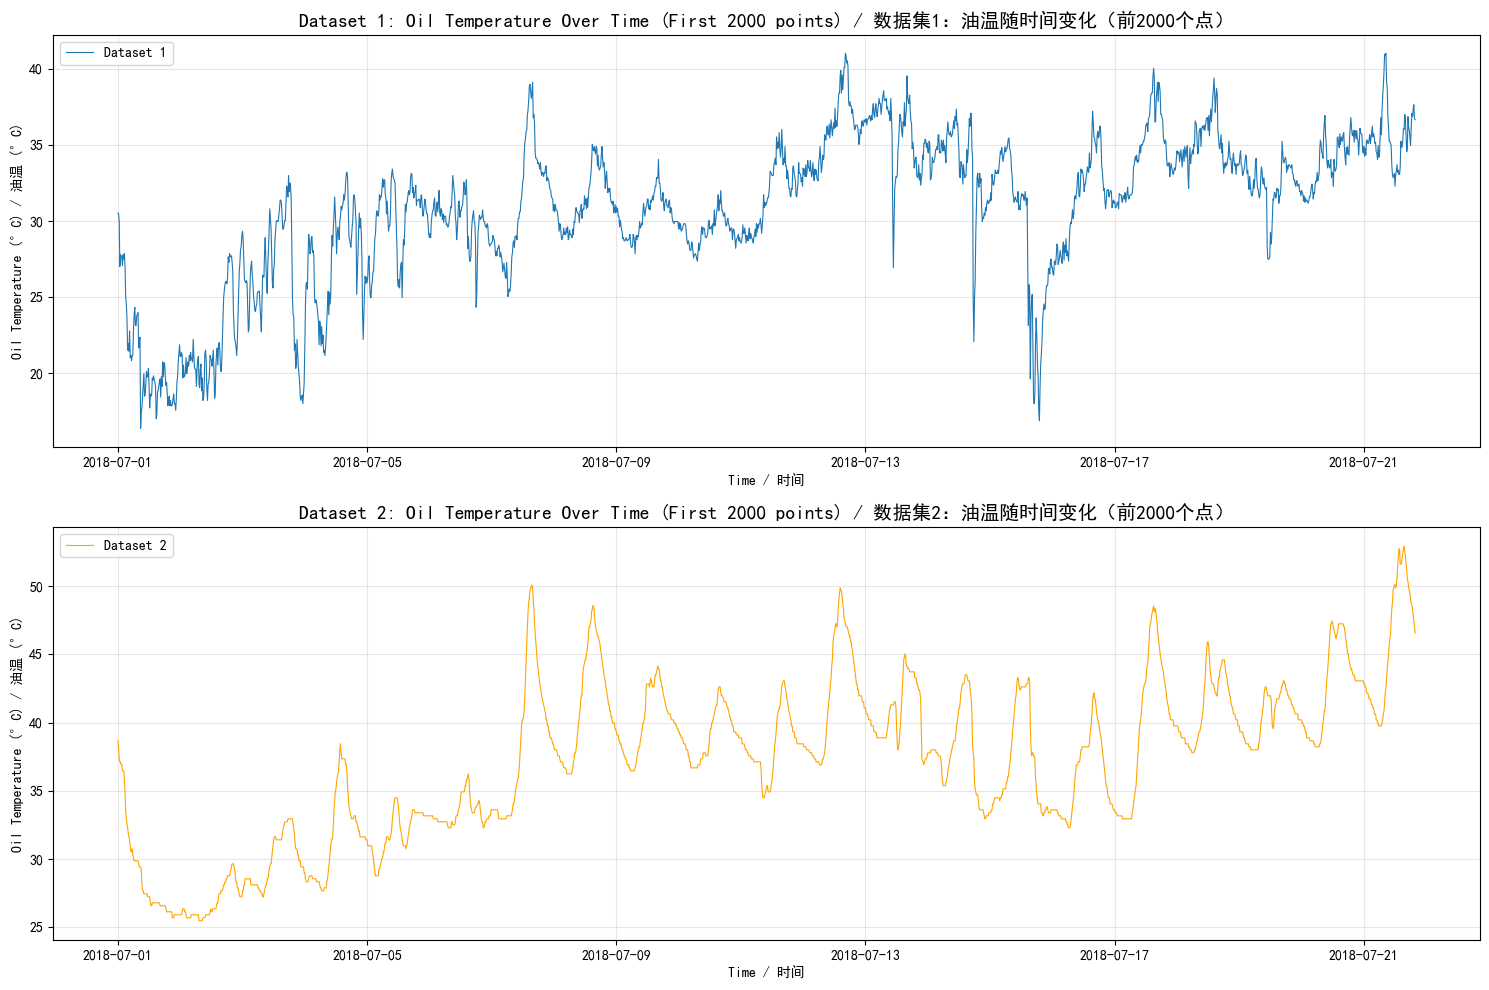

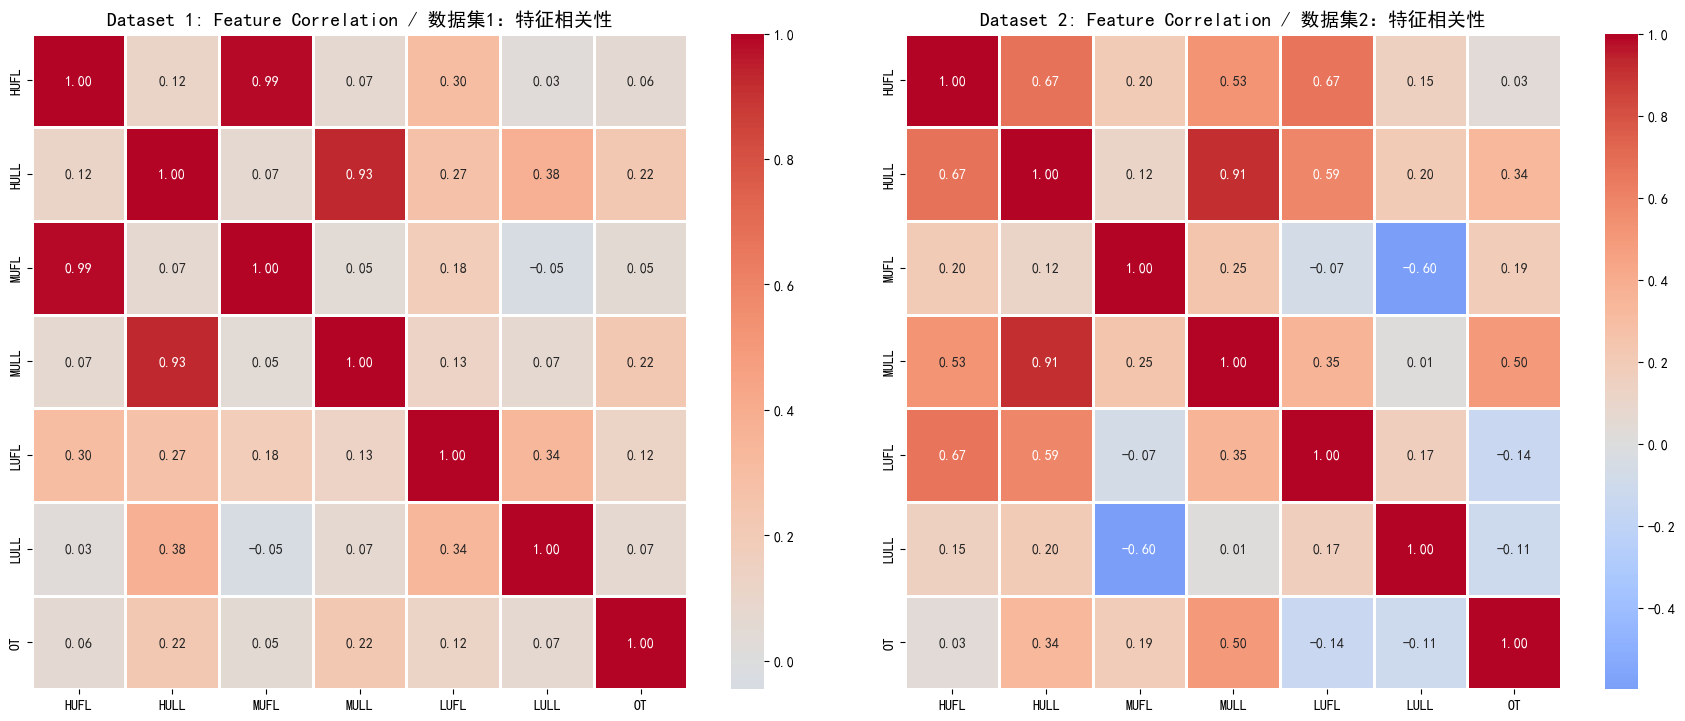

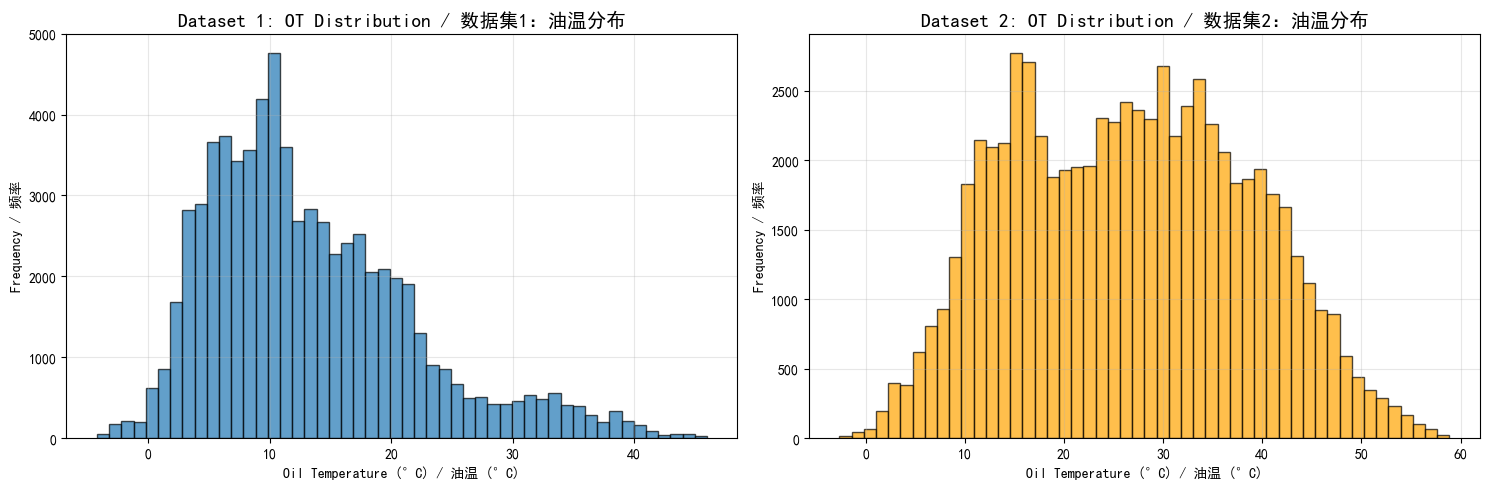

Observation / 观察:
Dataset 1 OT range / 数据集1油温范围: -4.22°C - 46.01°C
Dataset 2 OT range / 数据集2油温范围: -2.65°C - 58.88°C

Dataset 2 has higher temperature values / 数据集2具有更高的温度值


In [55]:
# Compare Oil Temperature between two datasets
# 比较两个数据集的油温
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Dataset 1 / 数据集 1
axes[0].plot(df_train1.index[:2000], df_train1['OT'][:2000], linewidth=0.8, label='Dataset 1')
axes[0].set_title('Dataset 1: Oil Temperature Over Time (First 2000 points) / 数据集1：油温随时间变化（前2000个点）', fontsize=14)
axes[0].set_xlabel('Time / 时间')
axes[0].set_ylabel('Oil Temperature (°C) / 油温 (°C)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Dataset 2 / 数据集 2
axes[1].plot(df_train2.index[:2000], df_train2['OT'][:2000], linewidth=0.8, label='Dataset 2', color='orange')
axes[1].set_title('Dataset 2: Oil Temperature Over Time (First 2000 points) / 数据集2：油温随时间变化（前2000个点）', fontsize=14)
axes[1].set_xlabel('Time / 时间')
axes[1].set_ylabel('Oil Temperature (°C) / 油温 (°C)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Correlation heatmaps for both datasets
# 两个数据集的相关性热力图
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Dataset 1
sns.heatmap(df_train1.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f', ax=axes[0])
axes[0].set_title('Dataset 1: Feature Correlation / 数据集1：特征相关性', fontsize=14)

# Dataset 2
sns.heatmap(df_train2.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f', ax=axes[1])
axes[1].set_title('Dataset 2: Feature Correlation / 数据集2：特征相关性', fontsize=14)

plt.tight_layout()
plt.show()

# Distribution comparison
# 分布对比
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_train1['OT'], bins=50, edgecolor='black', alpha=0.7, label='Dataset 1')
axes[0].set_title('Dataset 1: OT Distribution / 数据集1：油温分布', fontsize=14)
axes[0].set_xlabel('Oil Temperature (°C) / 油温 (°C)')
axes[0].set_ylabel('Frequency / 频率')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_train2['OT'], bins=50, edgecolor='black', alpha=0.7, color='orange', label='Dataset 2')
axes[1].set_title('Dataset 2: OT Distribution / 数据集2：油温分布', fontsize=14)
axes[1].set_xlabel('Oil Temperature (°C) / 油温 (°C)')
axes[1].set_ylabel('Frequency / 频率')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation / 观察:")
print(f"Dataset 1 OT range / 数据集1油温范围: {df_train1['OT'].min():.2f}°C - {df_train1['OT'].max():.2f}°C")
print(f"Dataset 2 OT range / 数据集2油温范围: {df_train2['OT'].min():.2f}°C - {df_train2['OT'].max():.2f}°C")
print(f"\nDataset 2 has higher temperature values / 数据集2具有更高的温度值")

## 步骤 4: 数据预处理 / Step 4: Data Preprocessing

### 4.1 特征和目标分离 / Feature and Target Separation

我们将特征（负载数据）与目标（OT - 油温）分离

We'll separate features (load data) from target (OT - Oil Temperature)

In [56]:
def prepare_features_target(df):
    """
    Separate features and target variable
    分离特征和目标变量
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    
    Returns:
    --------
    X : np.ndarray
        Features (all columns except OT)
    y : np.ndarray
        Target (OT column)
    """
    # Features: all columns except OT
    # 特征：除 OT 外的所有列
    X = df.drop('OT', axis=1).values
    # Target: OT (Oil Temperature)
    # 目标：OT（油温）
    y = df['OT'].values
    
    return X, y

# Process both datasets / 处理两个数据集
print("="*60)
print("Processing Dataset 1 / 处理数据集1")
print("="*60)
X1, y1 = prepare_features_target(df_train1)
print(f"Features shape / 特征形状: {X1.shape}")
print(f"Target shape / 目标形状: {y1.shape}")
print(f"Feature names / 特征名称: {df_train1.drop('OT', axis=1).columns.tolist()}")

print("\n" + "="*60)
print("Processing Dataset 2 / 处理数据集2")
print("="*60)
X2, y2 = prepare_features_target(df_train2)
print(f"Features shape / 特征形状: {X2.shape}")
print(f"Target shape / 目标形状: {y2.shape}")
print(f"Feature names / 特征名称: {df_train2.drop('OT', axis=1).columns.tolist()}")

Processing Dataset 1 / 处理数据集1
Features shape / 特征形状: (69680, 6)
Target shape / 目标形状: (69680,)
Feature names / 特征名称: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

Processing Dataset 2 / 处理数据集2
Features shape / 特征形状: (69680, 6)
Target shape / 目标形状: (69680,)
Feature names / 特征名称: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']


### 4.2 数据标准化 / Data Normalization

标准化特征和目标以提高 RNN 训练稳定性和收敛性

Normalize features and target to improve RNN training stability and convergence

In [57]:
def normalize_data(X, y):
    """
    Normalize features and target using StandardScaler
    使用 StandardScaler 标准化特征和目标
    
    Parameters:
    -----------
    X : np.ndarray
        Features
    y : np.ndarray
        Target
    
    Returns:
    --------
    X_scaled : np.ndarray
        Normalized features
    y_scaled : np.ndarray
        Normalized target
    scaler_X : StandardScaler
        Fitted scaler for features
    scaler_y : StandardScaler
        Fitted scaler for target
    """
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    return X_scaled, y_scaled, scaler_X, scaler_y

# Normalize Dataset 1 / 归一化数据集1
print("="*60)
print("Normalizing Dataset 1 / 归一化数据集1")
print("="*60)
X1_scaled, y1_scaled, scaler_X1, scaler_y1 = normalize_data(X1, y1)
print("Data normalized successfully! / 数据标准化成功！")
print(f"Features - Mean: {X1_scaled.mean():.4f}, Std: {X1_scaled.std():.4f}")
print(f"Target - Mean: {y1_scaled.mean():.4f}, Std: {y1_scaled.std():.4f}")

# Normalize Dataset 2 / 归一化数据集2
print("\n" + "="*60)
print("Normalizing Dataset 2 / 归一化数据集2")
print("="*60)
X2_scaled, y2_scaled, scaler_X2, scaler_y2 = normalize_data(X2, y2)
print("Data normalized successfully! / 数据标准化成功！")
print(f"Features - Mean: {X2_scaled.mean():.4f}, Std: {X2_scaled.std():.4f}")
print(f"Target - Mean: {y2_scaled.mean():.4f}, Std: {y2_scaled.std():.4f}")

Normalizing Dataset 1 / 归一化数据集1
Data normalized successfully! / 数据标准化成功！
Features - Mean: -0.0000, Std: 1.0000
Target - Mean: -0.0000, Std: 1.0000

Normalizing Dataset 2 / 归一化数据集2
Data normalized successfully! / 数据标准化成功！
Features - Mean: -0.0000, Std: 1.0000
Target - Mean: 0.0000, Std: 1.0000


### 4.3 创建时间序列序列 / Create Time Series Sequences

将数据转换为 RNN 输入序列。我们使用滑动窗口方法：

Transform data into sequences for RNN input. We use a sliding window approach:
- 输入：过去 `seq_length` 个时间步 / Input: Past `seq_length` time steps
- 输出：下一个时间步的油温 / Output: Next time step's oil temperature

In [58]:
# Define prediction configurations / 定义预测配置
# Based on dataset.md requirements / 基于 dataset.md 的要求

PREDICTION_CONFIGS = {
    'hour': {
        'name': 'Hour / 小时',
        'offset': 4,      # Start from 4 time points before target / 从目标前4个时间点开始
        'seq_length': 24, # Use 24 time points (1.5 hours, tunable) / 使用24个时间点（1.5小时，可调）
        'description': 'Predict 1 hour ahead / 预测1小时后'
    },
    'day': {
        'name': 'Day / 天',
        'offset': 96,     # Start from 96 time points before target (1 day) / 从目标前96个时间点开始（1天）
        'seq_length': 96, # Use 96 time points (1 day, tunable) / 使用96个时间点（1天，可调）
        'description': 'Predict 1 day ahead / 预测1天后'
    },
    'week': {
        'name': 'Week / 周',
        'offset': 672,    # Start from 672 time points before target (1 week) / 从目标前672个时间点开始（1周）
        'seq_length': 168, # Use 168 time points (1 week, tunable) / 使用168个时间点（1周，可调）
        'description': 'Predict 1 week ahead / 预测1周后'
    }
}

print("="*60)
print("Prediction Configurations / 预测配置")
print("="*60)
for key, config in PREDICTION_CONFIGS.items():
    print(f"\n{key.upper()}:")
    print(f"  {config['description']}")
    print(f"  Offset / 偏移: {config['offset']} time points")
    print(f"  Sequence Length / 序列长度: {config['seq_length']} time points")
    print(f"  Total lookback / 总回溯: {config['offset'] + config['seq_length']} time points")
print("="*60)

print("\nNote / 注意:")
print("- Sequence length (N) is tunable for optimization")
print("  序列长度 N 可调整以优化性能")
print("- We will train 6 models total: 2 datasets × 3 prediction horizons")
print("  我们将训练6个模型：2个数据集 × 3种预测时间范围")

Prediction Configurations / 预测配置

HOUR:
  Predict 1 hour ahead / 预测1小时后
  Offset / 偏移: 4 time points
  Sequence Length / 序列长度: 24 time points
  Total lookback / 总回溯: 28 time points

DAY:
  Predict 1 day ahead / 预测1天后
  Offset / 偏移: 96 time points
  Sequence Length / 序列长度: 96 time points
  Total lookback / 总回溯: 192 time points

WEEK:
  Predict 1 week ahead / 预测1周后
  Offset / 偏移: 672 time points
  Sequence Length / 序列长度: 168 time points
  Total lookback / 总回溯: 840 time points

Note / 注意:
- Sequence length (N) is tunable for optimization
  序列长度 N 可调整以优化性能
- We will train 6 models total: 2 datasets × 3 prediction horizons
  我们将训练6个模型：2个数据集 × 3种预测时间范围


In [59]:
def create_sequences_with_offset(X, y, seq_length=24, offset=4):
    """
    Create sequences for time series prediction with offset
    创建带偏移的时间序列预测序列
    
    Parameters:
    -----------
    X : np.ndarray
        Features array
    y : np.ndarray
        Target array
    seq_length : int
        Number of time steps to look back (default: 24)
        回溯的时间步数（默认：24）
    offset : int
        Prediction time offset from current point
        从当前点预测的时间偏移
        - offset=4: predict 1 hour ahead (4 × 15min = 1 hour)
        - offset=96: predict 1 day ahead (96 × 15min = 24 hours)
        - offset=672: predict 1 week ahead (672 × 15min = 7 days)
    
    Returns:
    --------
    X_seq : np.ndarray
        Sequences of features (samples, seq_length, n_features)
        From time t-offset-seq_length to t-offset-1
    y_seq : np.ndarray
        Target values at time t (future target)
        
    Example / 示例:
    ---------------
    For predicting 1 hour ahead (offset=4, seq_length=24):
    - To predict at time t=100:
      - Input: X[72:96] (from t-28 to t-5, excluding t-4 to t-1)
      - Target: y[100] (the value at t)
    """
    X_seq = []
    y_seq = []
    
    # Total lookback required / 需要的总回溯长度
    total_lookback = offset + seq_length
    
    # Start from where we have enough history / 从有足够历史数据的地方开始
    for i in range(total_lookback, len(X)):
        # Input sequence: from t-offset-seq_length to t-offset-1
        # 输入序列：从 t-offset-seq_length 到 t-offset-1
        seq_start = i - offset - seq_length
        seq_end = i - offset
        X_seq.append(X[seq_start:seq_end])
        
        # Target: value at time t (future point)
        # 目标：时间点 t 的值（未来点）
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

# Demonstrate with default configuration (hour prediction)
# 使用默认配置演示（小时预测）
seq_length_demo = 24
offset_demo = 4

print("="*60)
print("Sequence Creation Demo / 序列创建演示")
print("="*60)
print(f"Demo configuration: Hour prediction / 演示配置：小时预测")
print(f"  Sequence length: {seq_length_demo}")
print(f"  Offset: {offset_demo}")
print(f"  Total lookback: {seq_length_demo + offset_demo} time points")

print(f"\nExample / 示例:")
print(f"  To predict at time t=100:")
print(f"    - Input: time points {100-offset_demo-seq_length_demo} to {100-offset_demo-1}")
print(f"             (t-{offset_demo+seq_length_demo} to t-{offset_demo+1})")
print(f"    - Target: time point {100} (t)")
print(f"\n  为了预测时间点 t=100:")
print(f"    - 输入：时间点 {100-offset_demo-seq_length_demo} 到 {100-offset_demo-1}")
print(f"    - 目标：时间点 {100}")
print("="*60)

print("\nNote: We will create sequences for each prediction configuration later")
print("注意：我们稍后会为每种预测配置创建序列")

Sequence Creation Demo / 序列创建演示
Demo configuration: Hour prediction / 演示配置：小时预测
  Sequence length: 24
  Offset: 4
  Total lookback: 28 time points

Example / 示例:
  To predict at time t=100:
    - Input: time points 72 to 95
             (t-28 to t-5)
    - Target: time point 100 (t)

  为了预测时间点 t=100:
    - 输入：时间点 72 到 95
    - 目标：时间点 100

Note: We will create sequences for each prediction configuration later
注意：我们稍后会为每种预测配置创建序列


### 4.4 训练集/测试集分割 / Train/Test Split

将数据分割为训练集和测试集。对于时间序列，我们使用时间分割（非随机）。

Split data into training and testing sets. For time series, we use temporal split (not random).

In [60]:
# Implement group-based train/test split as recommended in dataset.md
# 按照 dataset.md 推荐的方式实现基于分组的训练/测试拆分

def split_into_groups(data_length, n_groups=20):
    """
    Divide data into n_groups of continuous time point groups
    将数据分成 n_groups 个连续的时间点组
    
    Parameters:
    -----------
    data_length : int
        Total length of data
    n_groups : int
        Number of groups to split into (default: 20)
    
    Returns:
    --------
    groups : list of tuples
        List of (start_idx, end_idx) for each group
    """
    group_size = data_length // n_groups
    groups = []
    
    for i in range(n_groups):
        start_idx = i * group_size
        # Last group takes all remaining data
        end_idx = start_idx + group_size if i < n_groups - 1 else data_length
        groups.append((start_idx, end_idx))
    
    return groups

def split_train_test_by_groups(X_seq, y_seq, train_ratio=0.8, n_groups=20, random_seed=42):
    """
    Split data by groups as recommended in dataset.md:
    按照 dataset.md 推荐的方式按组拆分数据：
    
    1. Divide data into n_groups continuous blocks
       将数据分成 n_groups 个连续块
    2. Randomly select train_ratio of groups for training
       随机选择 train_ratio 的组作为训练集
    3. Remaining groups for testing
       剩余的组作为测试集
    
    This ensures training and test data are completely disjoint
    这确保训练和测试数据完全不重叠
    
    Parameters:
    -----------
    X_seq, y_seq : np.ndarray
        Sequence data
    train_ratio : float
        Proportion of groups for training (default: 0.8 = 16 out of 20 groups)
    n_groups : int
        Number of groups to split into (default: 20)
    random_seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    X_train, X_test, y_train, y_test
    """
    np.random.seed(random_seed)
    
    # Get group indices
    groups = split_into_groups(len(X_seq), n_groups)
    n_train_groups = int(n_groups * train_ratio)
    
    # Randomly select training groups
    # 随机选择训练组
    group_indices = np.arange(n_groups)
    np.random.shuffle(group_indices)
    train_group_indices = sorted(group_indices[:n_train_groups])
    test_group_indices = sorted(group_indices[n_train_groups:])
    
    # Extract data from selected groups
    # 从选定的组中提取数据
    train_data_X = []
    train_data_y = []
    test_data_X = []
    test_data_y = []
    
    for idx in train_group_indices:
        start, end = groups[idx]
        train_data_X.append(X_seq[start:end])
        train_data_y.append(y_seq[start:end])
    
    for idx in test_group_indices:
        start, end = groups[idx]
        test_data_X.append(X_seq[start:end])
        test_data_y.append(y_seq[start:end])
    
    X_train = np.concatenate(train_data_X, axis=0)
    y_train = np.concatenate(train_data_y, axis=0)
    X_test = np.concatenate(test_data_X, axis=0)
    y_test = np.concatenate(test_data_y, axis=0)
    
    return X_train, X_test, y_train, y_test, train_group_indices, test_group_indices

# Demo: Show the splitting strategy
# 演示：展示拆分策略
print("="*60)
print("Group-Based Data Splitting Strategy / 基于分组的数据拆分策略")
print("="*60)
print("\nAs recommended in dataset.md:")
print("按照 dataset.md 的建议：")
print("\n1. Divide data into 20 continuous time point groups")
print("   将数据分成20个连续的时间点组")
print("2. Randomly select 80% (16 groups) for training")
print("   随机选择80%（16组）用于训练")
print("3. Remaining 20% (4 groups) for testing")
print("   剩余20%（4组）用于测试")
print("\nAdvantages / 优势:")
print("✓ Training and test data are completely disjoint")
print("  训练和测试数据完全不重叠")
print("✓ Maintains temporal continuity within each group")
print("  保持每组内的时间连续性")
print("✓ Random selection reduces bias")
print("  随机选择减少偏差")
print("="*60)

print("\nNote: Actual splitting will be performed during model training")
print("注意：实际拆分将在模型训练期间执行")

Group-Based Data Splitting Strategy / 基于分组的数据拆分策略

As recommended in dataset.md:
按照 dataset.md 的建议：

1. Divide data into 20 continuous time point groups
   将数据分成20个连续的时间点组
2. Randomly select 80% (16 groups) for training
   随机选择80%（16组）用于训练
3. Remaining 20% (4 groups) for testing
   剩余20%（4组）用于测试

Advantages / 优势:
✓ Training and test data are completely disjoint
  训练和测试数据完全不重叠
✓ Maintains temporal continuity within each group
  保持每组内的时间连续性
✓ Random selection reduces bias
  随机选择减少偏差

Note: Actual splitting will be performed during model training
注意：实际拆分将在模型训练期间执行


## 步骤 5: 构建 RNN 模型 / Step 5: Build RNN Model

我们将构建一个简单的 RNN 模型，包含：

We'll build a Simple RNN model with:
- 输入层：特征序列 / Input layer: sequences of features
- RNN 层：捕获时间依赖关系 / RNN layers: to capture temporal dependencies
- Dropout 层：用于正则化 / Dropout layers: for regularization
- 全连接输出层：用于回归 / Dense output layer: for regression

In [61]:
# Helper function to create DataLoaders / 创建数据加载器的辅助函数

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    """
    Create PyTorch DataLoaders from numpy arrays
    从numpy数组创建PyTorch DataLoader
    
    Parameters:
    -----------
    X_train, y_train : np.ndarray
        Training features and labels / 训练特征和标签
    X_test, y_test : np.ndarray
        Test features and labels / 测试特征和标签
    batch_size : int
        Batch size for training / 训练批次大小
        
    Returns:
    --------
    train_loader, test_loader : DataLoader
        Training and test data loaders / 训练和测试数据加载器
    """
    # Convert numpy arrays to PyTorch tensors / 将numpy数组转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # Add dimension for labels
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
    
    # Create TensorDatasets / 创建TensorDataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create DataLoaders / 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

print("="*60)
print("create_dataloaders function defined successfully!")
print("create_dataloaders 函数定义成功！")
print("="*60)

create_dataloaders function defined successfully!
create_dataloaders 函数定义成功！


In [62]:
# Define Simple RNN Model class / 定义简单RNN模型类

class SimpleRNNModel(nn.Module):
    """
    Simple RNN model for time series prediction
    用于时间序列预测的简单RNN模型
    
    Architecture / 架构:
    - Multiple RNN layers with dropout / 多个带dropout的RNN层
    - Fully connected output layers / 全连接输出层
    """
    def __init__(self, input_size, hidden_sizes, dropout=0.2):
        """
        Parameters:
        -----------
        input_size : int
            Number of input features / 输入特征数
        hidden_sizes : list of int
            List of hidden layer sizes for RNN / RNN隐藏层大小列表
        dropout : float
            Dropout rate / Dropout率
        """
        super(SimpleRNNModel, self).__init__()
        
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        
        # Create RNN layers / 创建RNN层
        self.rnn_layers = nn.ModuleList()
        
        # First RNN layer / 第一个RNN层
        self.rnn_layers.append(
            nn.RNN(input_size, hidden_sizes[0], batch_first=True)
        )
        
        # Additional RNN layers / 额外的RNN层
        for i in range(1, self.num_layers):
            self.rnn_layers.append(
                nn.RNN(hidden_sizes[i-1], hidden_sizes[i], batch_first=True)
            )
        
        # Dropout layers / Dropout层
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers / 全连接层
        self.fc1 = nn.Linear(hidden_sizes[-1], 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        """
        Forward pass / 前向传播
        
        Parameters:
        -----------
        x : torch.Tensor
            Input sequences (batch_size, seq_length, input_size)
        
        Returns:
        --------
        out : torch.Tensor
            Predictions (batch_size, 1)
        """
        # Pass through RNN layers / 通过RNN层
        for i, rnn_layer in enumerate(self.rnn_layers):
            x, _ = rnn_layer(x)
            x = self.dropout(x)
        
        # Take the last time step output / 取最后一个时间步的输出
        x = x[:, -1, :]
        
        # Pass through fully connected layers / 通过全连接层
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

print("="*60)
print("SimpleRNNModel class defined successfully!")
print("SimpleRNNModel 类定义成功！")
print("="*60)

SimpleRNNModel class defined successfully!
SimpleRNNModel 类定义成功！


In [63]:
# Model architecture remains the same from previous cell (Simple RNNModel)
# 模型架构与之前的cell相同（SimpleRNNModel）

# Model parameters / 模型参数
input_size = 6  # Number of features: HUFL, HULL, MUFL, MULL, LUFL, LULL / 特征数量
hidden_sizes = [64, 32]  # RNN hidden units / RNN 隐藏单元
dropout = 0.2  # Dropout rate / Dropout 率

print("="*60)
print("Model Architecture / 模型架构")
print("="*60)
print(f"\nSimpleRNNModel:")
print(f"  Input size / 输入大小: {input_size} features")
print(f"  Hidden layers / 隐藏层: {hidden_sizes}")
print(f"  Dropout rate / Dropout率: {dropout}")
print(f"\nArchitecture flow / 架构流程:")
print(f"  {input_size} (features) → RNN({hidden_sizes[0]}) → Dropout({dropout})")
print(f"  → RNN({hidden_sizes[1]}) → Dropout({dropout})")
print(f"  → FC(16) → ReLU → Dropout → FC(1)")
print(f"\nOutput / 输出: Single value (oil temperature prediction)")
print(f"        单个值（油温预测）")
print("="*60)

# Create a sample model to count parameters / 创建示例模型以统计参数
sample_model = SimpleRNNModel(input_size, hidden_sizes, dropout)
total_params = sum(p.numel() for p in sample_model.parameters())
trainable_params = sum(p.numel() for p in sample_model.parameters() if p.requires_grad)

print(f"\nModel Parameters / 模型参数:")
print(f"  Total / 总数: {total_params:,}")
print(f"  Trainable / 可训练: {trainable_params:,}")
print("="*60)

print("\nNote: We will create 6 instances of this model architecture")
print("注意：我们将创建此模型架构的6个实例")
print("  - 2 datasets × 3 prediction horizons = 6 models")
print("  - 2个数据集 × 3种预测时间范围 = 6个模型")

Model Architecture / 模型架构

SimpleRNNModel:
  Input size / 输入大小: 6 features
  Hidden layers / 隐藏层: [64, 32]
  Dropout rate / Dropout率: 0.2

Architecture flow / 架构流程:
  6 (features) → RNN(64) → Dropout(0.2)
  → RNN(32) → Dropout(0.2)
  → FC(16) → ReLU → Dropout → FC(1)

Output / 输出: Single value (oil temperature prediction)
        单个值（油温预测）

Model Parameters / 模型参数:
  Total / 总数: 8,289
  Trainable / 可训练: 8,289

Note: We will create 6 instances of this model architecture
注意：我们将创建此模型架构的6个实例
  - 2 datasets × 3 prediction horizons = 6 models
  - 2个数据集 × 3种预测时间范围 = 6个模型


In [64]:
# Define training function / 定义训练函数

def train_rnn_model(train_loader, test_loader, input_size, hidden_sizes, dropout=0.2,
                    num_epochs=100, lr=0.001, patience=10, dataset_name='Model', device='cpu'):
    """
    Train the RNN model with early stopping
    使用早停训练RNN模型
    
    Parameters:
    -----------
    train_loader, test_loader : DataLoader
        Training and test data loaders
    input_size : int
        Number of input features
    hidden_sizes : list of int
        Hidden layer sizes
    dropout : float
        Dropout rate
    num_epochs : int
        Maximum number of epochs
    lr : float
        Learning rate
    patience : int
        Early stopping patience
    dataset_name : str
        Name for logging
    device : str or torch.device
        Device to train on
    
    Returns:
    --------
    model : SimpleRNNModel
        Trained model
    history : dict
        Training history with train/test loss and MAE
    """
    # Initialize model / 初始化模型
    model = SimpleRNNModel(input_size, hidden_sizes, dropout).to(device)
    
    # Loss function and optimizer / 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Learning rate scheduler / 学习率调度器
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training history / 训练历史
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_mae': [],
        'test_mae': []
    }
    
    # Early stopping variables / 早停变量
    best_test_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"Training {dataset_name}...")
    print(f"训练 {dataset_name}...")
    
    for epoch in range(num_epochs):
        # Training phase / 训练阶段
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass / 前向传播
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            
            # Backward pass / 反向传播
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            train_mae += torch.abs(outputs - y_batch).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)
        
        # Test phase / 测试阶段
        model.eval()
        test_loss = 0.0
        test_mae = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                
                test_loss += loss.item() * X_batch.size(0)
                test_mae += torch.abs(outputs - y_batch).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_mae /= len(test_loader.dataset)
        
        # Update history / 更新历史
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_mae'].append(train_mae)
        history['test_mae'].append(test_mae)
        
        # Learning rate scheduling / 学习率调度
        scheduler.step(test_loss)
        
        # Print progress every 10 epochs / 每10个轮次打印进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {train_loss:.6f}, Train MAE: {train_mae:.6f} | '
                  f'Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}')
        
        # Early stopping check / 早停检查
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            print(f'在第 {epoch+1} 轮触发早停')
            break
    
    # Load best model / 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f'\nTraining completed! Best test loss: {best_test_loss:.6f}')
    print(f'训练完成！最佳测试损失: {best_test_loss:.6f}\n')
    
    return model, history

print("="*60)
print("train_rnn_model function defined successfully!")
print("train_rnn_model 函数定义成功！")
print("="*60)

train_rnn_model function defined successfully!
train_rnn_model 函数定义成功！


## 步骤 6: 训练模型 / Step 6: Train the Model

使用以下方法训练 RNN：

Train the RNN with:
- Adam 优化器 / Adam optimizer
- MSE 损失函数 / MSE loss function
- 学习率调度器：提高收敛性 / Learning rate scheduler: improve convergence
- 早停：防止过拟合 / Early stopping: prevent overfitting

In [65]:
# Training all 6 models: 2 datasets × 3 prediction horizons
# 训练所有6个模型：2个数据集 × 3种预测时间范围

# Storage for all models and results / 存储所有模型和结果
all_models = {}
all_histories = {}
all_predictions = {}
all_metrics = {}
all_scalers = {}
all_data_info = {}

# Datasets configuration / 数据集配置
datasets_config = {
    'Dataset1': {'df': df_train1, 'X': X1, 'y': y1, 'scaler_X': scaler_X1, 'scaler_y': scaler_y1},
    'Dataset2': {'df': df_train2, 'X': X2, 'y': y2, 'scaler_X': scaler_X2, 'scaler_y': scaler_y2}
}

# Training hyperparameters / 训练超参数
num_epochs = 100
learning_rate = 0.001
patience = 10
batch_size = 32
n_groups = 20
train_ratio = 0.8

print("\n" + "="*80)
print("TRAINING 6 RNN MODELS / 训练6个RNN模型")
print("="*80)
print(f"Configuration / 配置:")
print(f"  Datasets / 数据集: 2 (Dataset1, Dataset2)")
print(f"  Prediction horizons / 预测时间范围: 3 (hour, day, week)")
print(f"  Total models / 总模型数: 6")
print(f"  Epochs / 轮数: {num_epochs}")
print(f"  Batch size / 批次大小: {batch_size}")
print(f"  Data split / 数据拆分: {n_groups} groups, {int(train_ratio*100)}% train")
print("="*80)

# Train each model / 训练每个模型
model_counter = 0

for dataset_name, dataset_config in datasets_config.items():
    for pred_key, pred_config in PREDICTION_CONFIGS.items():
        model_counter += 1
        model_name = f"{dataset_name}_{pred_key}"
        
        print(f"\n{'='*80}")
        print(f"[{model_counter}/6] Training Model: {model_name}")
        print(f"[{model_counter}/6] 训练模型：{model_name}")
        print(f"{'='*80}")
        print(f"Configuration / 配置:")
        print(f"  Dataset / 数据集: {dataset_name}")
        print(f"  Prediction type / 预测类型: {pred_config['description']}")
        print(f"  Offset / 偏移: {pred_config['offset']} time points")
        print(f"  Sequence length / 序列长度: {pred_config['seq_length']} time points")
        print(f"  Total lookback / 总回溯: {pred_config['offset'] + pred_config['seq_length']} time points")
        print(f"{'='*80}\n")
        
        # 1. Get data / 获取数据
        X_scaled = dataset_config['scaler_X'].transform(dataset_config['X'])
        y_scaled = dataset_config['scaler_y'].transform(dataset_config['y'].reshape(-1, 1)).flatten()
        
        # 2. Create sequences with offset / 使用偏移创建序列
        X_seq, y_seq = create_sequences_with_offset(
            X_scaled, y_scaled,
            seq_length=pred_config['seq_length'],
            offset=pred_config['offset']
        )
        
        print(f"Created {len(X_seq):,} sequences / 创建了{len(X_seq):,}个序列")
        
        # 3. Split data by groups / 按组拆分数据
        X_train, X_test, y_train, y_test, train_groups, test_groups = split_train_test_by_groups(
            X_seq, y_seq, train_ratio=train_ratio, n_groups=n_groups
        )
        
        print(f"Split into groups / 拆分为组:")
        print(f"  Train groups / 训练组: {train_groups}")
        print(f"  Test groups / 测试组: {test_groups}")
        print(f"  Train samples / 训练样本: {len(X_train):,}")
        print(f"  Test samples / 测试样本: {len(X_test):,}\n")
        
        # 4. Create DataLoaders / 创建数据加载器
        train_loader, test_loader = create_dataloaders(
            X_train, y_train, X_test, y_test, batch_size=batch_size
        )
        
        # 5. Train model / 训练模型
        print(f"Starting training... / 开始训练...\n")
        model, history = train_rnn_model(
            train_loader, test_loader,
            input_size=X_train.shape[2],
            hidden_sizes=hidden_sizes,
            dropout=dropout,
            num_epochs=num_epochs,
            lr=learning_rate,
            patience=patience,
            dataset_name=model_name,
            device=device
        )
        
        # 6. Store results / 存储结果
        all_models[model_name] = model
        all_histories[model_name] = history
        all_scalers[model_name] = dataset_config['scaler_y']
        all_data_info[model_name] = {
            'train_groups': train_groups,
            'test_groups': test_groups,
            'n_train': len(X_train),
            'n_test': len(X_test),
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'train_loader': train_loader,
            'test_loader': test_loader
        }
        
        print(f"\n✓ Model {model_name} training completed!")
        print(f"✓ 模型 {model_name} 训练完成！")
        print(f"  Best test loss: {min(history['test_loss']):.6f}")
        print(f"  最佳测试损失: {min(history['test_loss']):.6f}")

print("\n" + "="*80)
print("ALL 6 MODELS TRAINING COMPLETED! / 所有6个模型训练完成！")
print("="*80)
print(f"\nTrained models / 已训练模型:")
for i, model_name in enumerate(all_models.keys(), 1):
    best_loss = min(all_histories[model_name]['test_loss'])
    print(f"  {i}. {model_name}: Best Test Loss = {best_loss:.6f}")
print("="*80)


TRAINING 6 RNN MODELS / 训练6个RNN模型
Configuration / 配置:
  Datasets / 数据集: 2 (Dataset1, Dataset2)
  Prediction horizons / 预测时间范围: 3 (hour, day, week)
  Total models / 总模型数: 6
  Epochs / 轮数: 100
  Batch size / 批次大小: 32
  Data split / 数据拆分: 20 groups, 80% train

[1/6] Training Model: Dataset1_hour
[1/6] 训练模型：Dataset1_hour
Configuration / 配置:
  Dataset / 数据集: Dataset1
  Prediction type / 预测类型: Predict 1 hour ahead / 预测1小时后
  Offset / 偏移: 4 time points
  Sequence length / 序列长度: 24 time points
  Total lookback / 总回溯: 28 time points

Created 69,652 sequences / 创建了69,652个序列
Split into groups / 拆分为组:
  Train groups / 训练组: [0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19]
  Test groups / 测试组: [6, 7, 10, 14]
  Train samples / 训练样本: 55,724
  Test samples / 测试样本: 13,928

Starting training... / 开始训练...

Training Dataset1_hour...
训练 Dataset1_hour...
Epoch [10/100] - Train Loss: 1.085103, Train MAE: 26.088595 | Test Loss: 0.673863, Test MAE: 23.217928

Early stopping triggered at epoch 14
在第 14 

### 6.1 训练历史可视化 / Training History Visualization

绘制训练和验证损失曲线以检查过拟合

Plot training and validation loss curves to check for overfitting

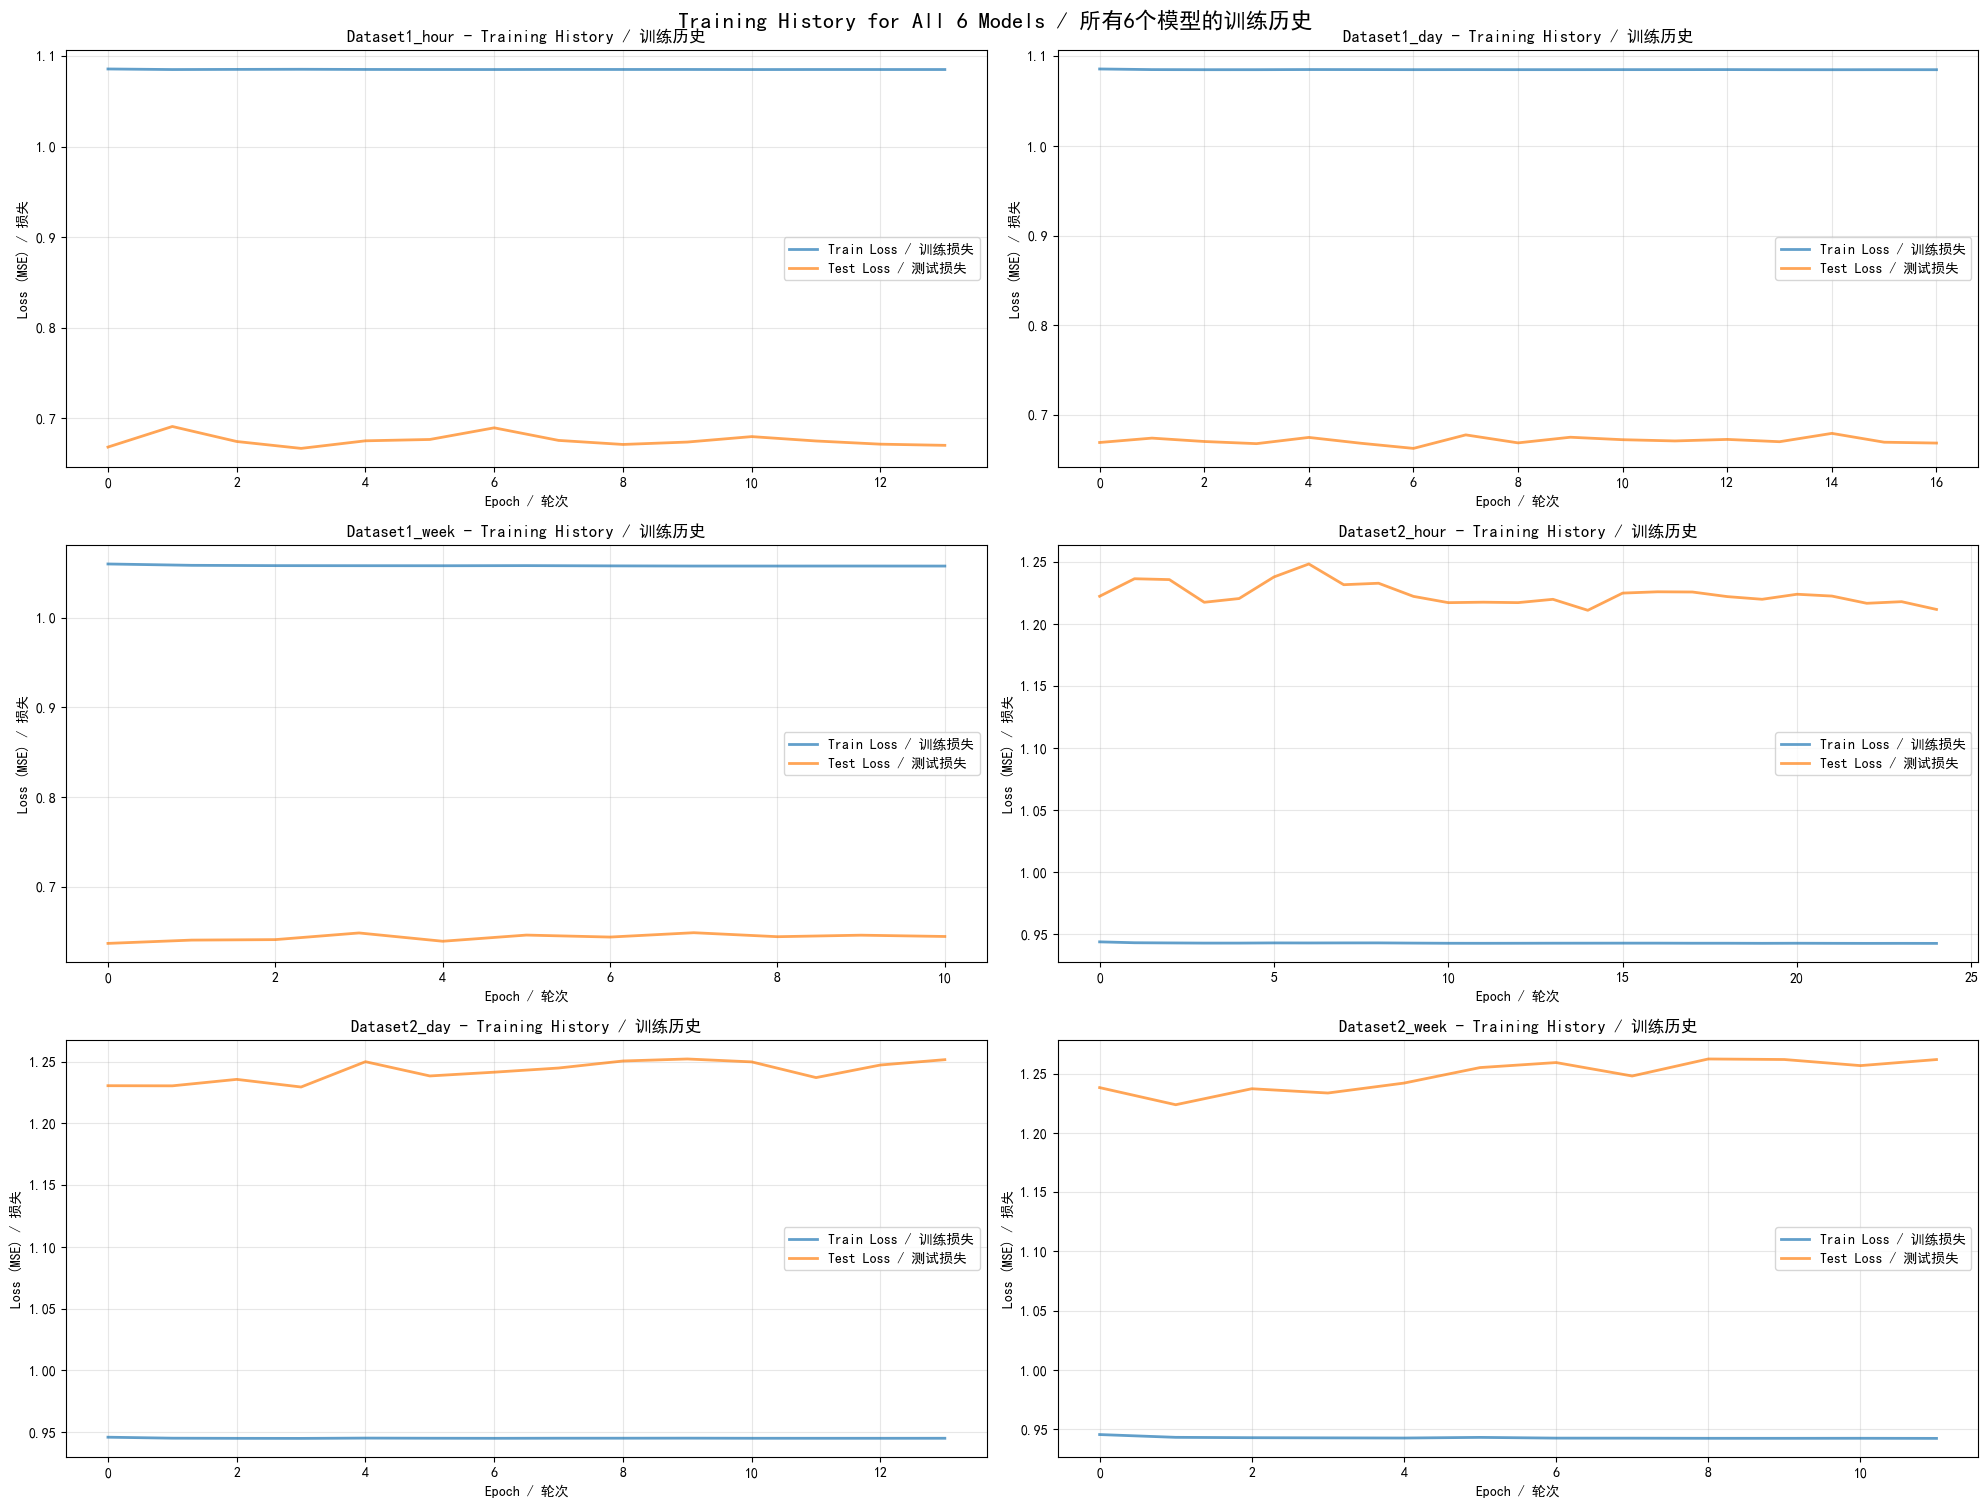

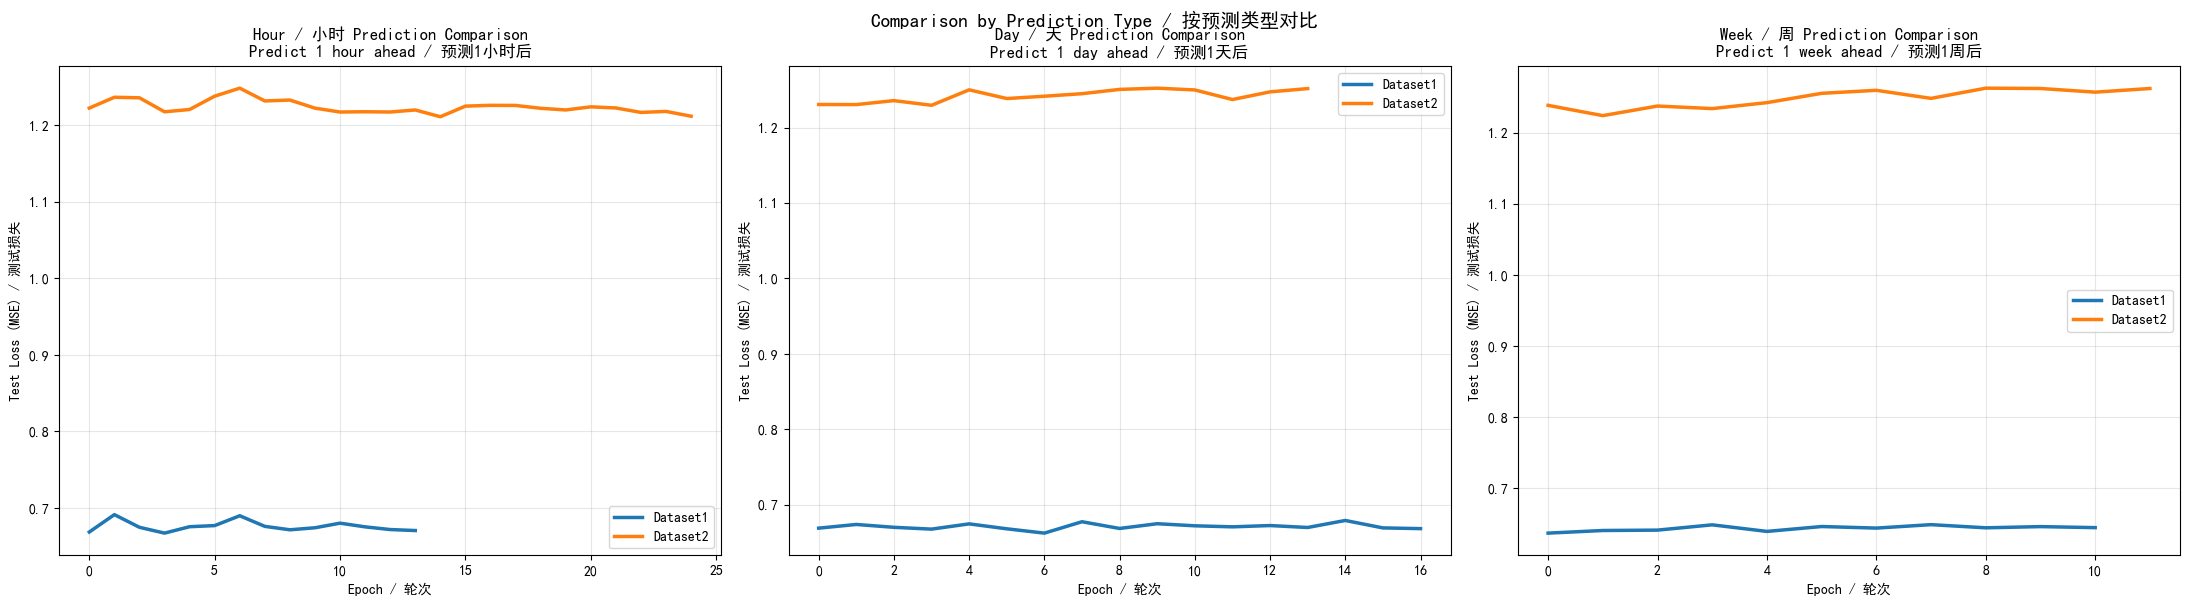

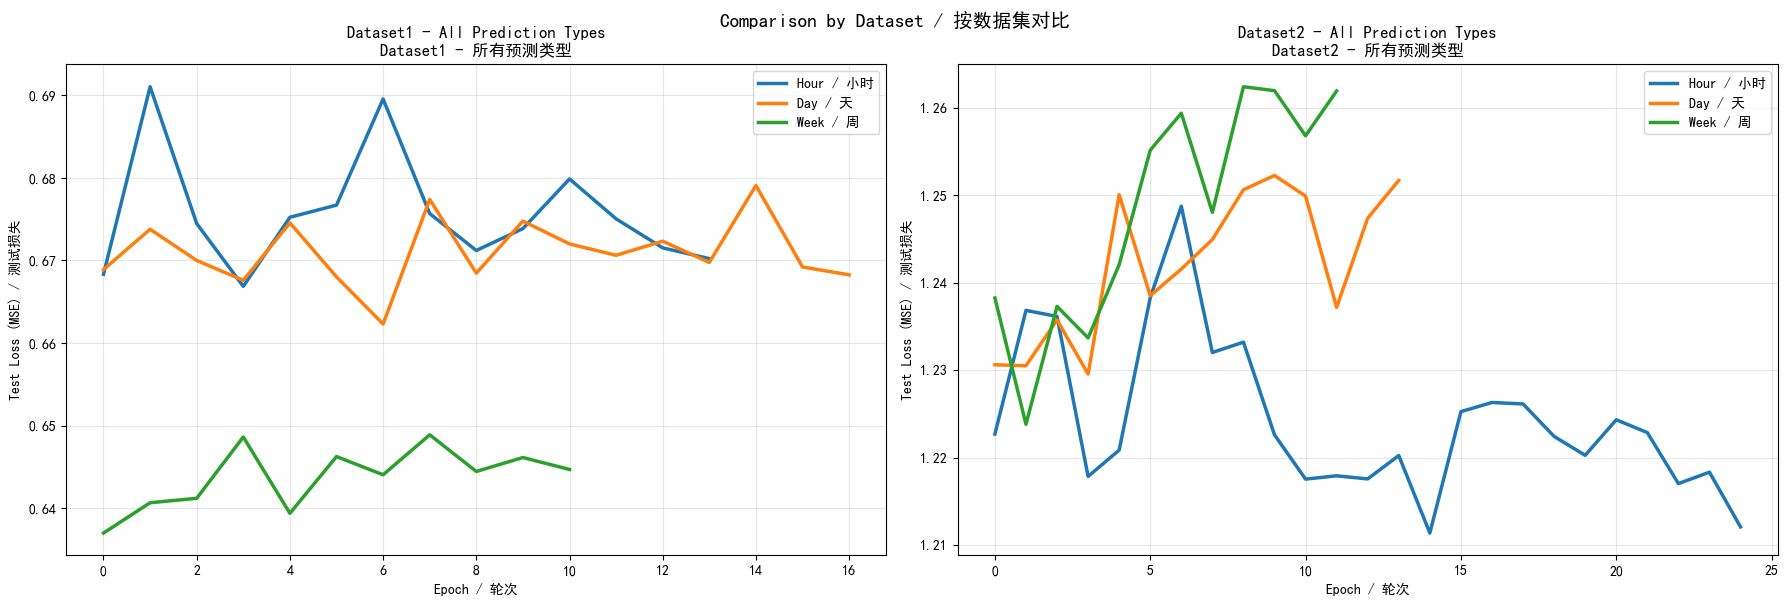

FINAL TRAINING METRICS SUMMARY / 最终训练指标总结

Dataset1_hour:
  Final Test Loss / 最终测试损失: 0.670229
  Best Test Loss / 最佳测试损失: 0.666865
  Final Test MAE / 最终测试MAE: 23.147029
  Best Test MAE / 最佳测试MAE: 23.069296

Dataset1_day:
  Final Test Loss / 最终测试损失: 0.668258
  Best Test Loss / 最佳测试损失: 0.662306
  Final Test MAE / 最终测试MAE: 23.110814
  Best Test MAE / 最佳测试MAE: 22.995954

Dataset1_week:
  Final Test Loss / 最终测试损失: 0.644688
  Best Test Loss / 最佳测试损失: 0.636989
  Final Test MAE / 最终测试MAE: 22.646843
  Best Test MAE / 最佳测试MAE: 22.438858

Dataset2_hour:
  Final Test Loss / 最终测试损失: 1.212083
  Best Test Loss / 最佳测试损失: 1.211380
  Final Test MAE / 最终测试MAE: 31.223076
  Best Test MAE / 最佳测试MAE: 31.091471

Dataset2_day:
  Final Test Loss / 最终测试损失: 1.251713
  Best Test Loss / 最佳测试损失: 1.229565
  Final Test MAE / 最终测试MAE: 31.707660
  Best Test MAE / 最佳测试MAE: 31.390585

Dataset2_week:
  Final Test Loss / 最终测试损失: 1.261937
  Best Test Loss / 最佳测试损失: 1.223815
  Final Test MAE / 最终测试MAE: 31.733565
  Best Test M

In [66]:
# Visualize training history for all 6 models / 可视化所有6个模型的训练历史

# 1. Individual model training histories / 各模型训练历史
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

model_names = list(all_histories.keys())
for idx, model_name in enumerate(model_names):
    history = all_histories[model_name]
    ax = axes[idx]
    
    ax.plot(history['train_loss'], label='Train Loss / 训练损失', linewidth=2, alpha=0.7)
    ax.plot(history['test_loss'], label='Test Loss / 测试损失', linewidth=2, alpha=0.7)
    ax.set_title(f'{model_name} - Training History / 训练历史', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch / 轮次')
    ax.set_ylabel('Loss (MSE) / 损失')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Training History for All 6 Models / 所有6个模型的训练历史', 
             fontsize=16, fontweight='bold', y=1.002)
plt.show()

# 2. Comparison by prediction type / 按预测类型对比
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for idx, pred_type in enumerate(['hour', 'day', 'week']):
    ax = axes[idx]
    
    for dataset in ['Dataset1', 'Dataset2']:
        model_name = f"{dataset}_{pred_type}"
        history = all_histories[model_name]
        ax.plot(history['test_loss'], label=dataset, linewidth=2.5)
    
    pred_config = PREDICTION_CONFIGS[pred_type]
    ax.set_title(f'{pred_config["name"]} Prediction Comparison\n{pred_config["description"]}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch / 轮次')
    ax.set_ylabel('Test Loss (MSE) / 测试损失')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comparison by Prediction Type / 按预测类型对比', 
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

# 3. Comparison by dataset / 按数据集对比
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for idx, dataset in enumerate(['Dataset1', 'Dataset2']):
    ax = axes[idx]
    
    for pred_type in ['hour', 'day', 'week']:
        model_name = f"{dataset}_{pred_type}"
        history = all_histories[model_name]
        pred_config = PREDICTION_CONFIGS[pred_type]
        ax.plot(history['test_loss'], label=pred_config['name'], linewidth=2.5)
    
    ax.set_title(f'{dataset} - All Prediction Types\n{dataset} - 所有预测类型', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch / 轮次')
    ax.set_ylabel('Test Loss (MSE) / 测试损失')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comparison by Dataset / 按数据集对比', 
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

# Print final metrics summary / 打印最终指标总结
print("="*80)
print("FINAL TRAINING METRICS SUMMARY / 最终训练指标总结")
print("="*80)
for model_name in model_names:
    history = all_histories[model_name]
    print(f"\n{model_name}:")
    print(f"  Final Test Loss / 最终测试损失: {history['test_loss'][-1]:.6f}")
    print(f"  Best Test Loss / 最佳测试损失: {min(history['test_loss']):.6f}")
    print(f"  Final Test MAE / 最终测试MAE: {history['test_mae'][-1]:.6f}")
    print(f"  Best Test MAE / 最佳测试MAE: {min(history['test_mae']):.6f}")
print("="*80)

## 步骤 7: 模型评估 / Step 7: Model Evaluation

### 7.1 生成预测 / Make Predictions

在测试集上生成预测并反向转换到原始尺度

Generate predictions on test set and inverse transform to original scale

In [67]:
# Define prediction function / 定义预测函数

def make_predictions(model, train_loader, test_loader, scaler_y, device='cpu'):
    """
    Generate predictions on train and test data
    在训练和测试数据上生成预测
    
    Parameters:
    -----------
    model : SimpleRNNModel
        Trained model
    train_loader, test_loader : DataLoader
        Data loaders
    scaler_y : StandardScaler
        Scaler for inverse transformation (not used here, but kept for compatibility)
    device : str or torch.device
        Device for inference
    
    Returns:
    --------
    y_train_pred : np.ndarray
        Training predictions (normalized scale)
    y_test_pred : np.ndarray
        Test predictions (normalized scale)
    """
    model.eval()
    
    # Training predictions / 训练预测
    train_predictions = []
    with torch.no_grad():
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).squeeze()
            train_predictions.append(outputs.cpu().numpy())
    
    y_train_pred = np.concatenate(train_predictions)
    
    # Test predictions / 测试预测
    test_predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).squeeze()
            test_predictions.append(outputs.cpu().numpy())
    
    y_test_pred = np.concatenate(test_predictions)
    
    return y_train_pred, y_test_pred

print("="*60)
print("make_predictions function defined successfully!")
print("make_predictions 函数定义成功！")
print("="*60)

make_predictions function defined successfully!
make_predictions 函数定义成功！


In [68]:
# Generate predictions for all 6 models / 为所有6个模型生成预测

print("="*80)
print("GENERATING PREDICTIONS FOR ALL 6 MODELS")
print("为所有6个模型生成预测")
print("="*80)

for model_name in all_models.keys():
    print(f"\nGenerating predictions for {model_name}...")
    print(f"为 {model_name} 生成预测...")
    
    model = all_models[model_name]
    scaler_y = all_scalers[model_name]
    data_info = all_data_info[model_name]
    
    # Generate predictions / 生成预测
    y_train_pred, y_test_pred = make_predictions(
        model, data_info['train_loader'], data_info['test_loader'], scaler_y, device
    )
    
    # Inverse transform to original scale / 反向转换到原始尺度
    y_train_actual = scaler_y.inverse_transform(data_info['y_train'].reshape(-1, 1)).flatten()
    y_train_pred_inv = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    y_test_actual = scaler_y.inverse_transform(data_info['y_test'].reshape(-1, 1)).flatten()
    y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    
    # Store predictions / 存储预测
    all_predictions[model_name] = {
        'y_train_actual': y_train_actual,
        'y_train_pred': y_train_pred_inv,
        'y_test_actual': y_test_actual,
        'y_test_pred': y_test_pred_inv
    }
    
    print(f"  ✓ Predictions generated / 预测已生成")
    print(f"    Train samples / 训练样本: {len(y_train_actual):,}")
    print(f"    Test samples / 测试样本: {len(y_test_actual):,}")

print("\n" + "="*80)
print("ALL PREDICTIONS GENERATED! / 所有预测已生成！")
print("="*80)

GENERATING PREDICTIONS FOR ALL 6 MODELS
为所有6个模型生成预测

Generating predictions for Dataset1_hour...
为 Dataset1_hour 生成预测...
  ✓ Predictions generated / 预测已生成
    Train samples / 训练样本: 55,724
    Test samples / 测试样本: 13,928

Generating predictions for Dataset1_day...
为 Dataset1_day 生成预测...
  ✓ Predictions generated / 预测已生成
    Train samples / 训练样本: 55,592
    Test samples / 测试样本: 13,896

Generating predictions for Dataset1_week...
为 Dataset1_week 生成预测...
  ✓ Predictions generated / 预测已生成
    Train samples / 训练样本: 55,072
    Test samples / 测试样本: 13,768

Generating predictions for Dataset2_hour...
为 Dataset2_hour 生成预测...
  ✓ Predictions generated / 预测已生成
    Train samples / 训练样本: 55,724
    Test samples / 测试样本: 13,928

Generating predictions for Dataset2_day...
为 Dataset2_day 生成预测...
  ✓ Predictions generated / 预测已生成
    Train samples / 训练样本: 55,592
    Test samples / 测试样本: 13,896

Generating predictions for Dataset2_week...
为 Dataset2_week 生成预测...
  ✓ Predictions generated / 预测已生成
    Train

### 7.2 计算评估指标 / Calculate Evaluation Metrics

计算标准回归指标以评估模型性能

Compute standard regression metrics to assess model performance

In [69]:
# Define metrics calculation function / 定义指标计算函数

def calculate_metrics(y_actual, y_pred, dataset_name='Dataset'):
    """
    Calculate regression metrics
    计算回归指标
    
    Parameters:
    -----------
    y_actual : np.ndarray
        Actual values
    y_pred : np.ndarray
        Predicted values
    dataset_name : str
        Name for display
    
    Returns:
    --------
    metrics : dict
        Dictionary containing R2, RMSE, MAE, MAPE
    """
    # R² Score / R²分数
    r2 = r2_score(y_actual, y_pred)
    
    # RMSE (Root Mean Squared Error) / 均方根误差
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    
    # MAE (Mean Absolute Error) / 平均绝对误差
    mae = mean_absolute_error(y_actual, y_pred)
    
    # MAPE (Mean Absolute Percentage Error) / 平均绝对百分比误差
    # Avoid division by zero / 避免除零错误
    mask = y_actual != 0
    mape = np.mean(np.abs((y_actual[mask] - y_pred[mask]) / y_actual[mask])) * 100
    
    # Store metrics / 存储指标
    metrics = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
    
    # Print metrics / 打印指标
    print(f"\n{dataset_name} Performance Metrics / {dataset_name} 性能指标:")
    print(f"  R² Score / R²分数: {r2:.4f}")
    print(f"  RMSE / 均方根误差: {rmse:.4f}°C")
    print(f"  MAE / 平均绝对误差: {mae:.4f}°C")
    print(f"  MAPE / 平均绝对百分比误差: {mape:.2f}%")
    
    return metrics

print("="*60)
print("calculate_metrics function defined successfully!")
print("calculate_metrics 函数定义成功！")
print("="*60)

calculate_metrics function defined successfully!
calculate_metrics 函数定义成功！


In [75]:
# Calculate metrics for all 6 models / 为所有6个模型计算指标

print("="*80)
print("CALCULATING METRICS FOR ALL 6 MODELS")
print("为所有6个模型计算指标")
print("="*80)

for model_name in all_models.keys():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} PERFORMANCE")
    print(f"{model_name.upper()} 性能")
    print(f"{'='*60}")
    
    preds = all_predictions[model_name]
    
    # Calculate metrics / 计算指标
    train_metrics = calculate_metrics(
        preds['y_train_actual'], preds['y_train_pred'], 'Training / 训练'
    )
    test_metrics = calculate_metrics(
        preds['y_test_actual'], preds['y_test_pred'], 'Test / 测试'
    )
    
    # Store metrics / 存储指标
    all_metrics[model_name] = {
        'train': train_metrics,
        'test': test_metrics
    }

# Create comprehensive comparison table / 创建综合对比表
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE COMPARISON / 综合性能对比")
print("="*80)

comparison_data = []
for model_name in all_models.keys():
    dataset, pred_type = model_name.split('_')
    test_metrics = all_metrics[model_name]['test']
    
    comparison_data.append({
        'Model / 模型': model_name,
        'Dataset / 数据集': dataset,
        'Prediction / 预测': pred_type,
        'R²': test_metrics['R2'],
        'RMSE (°C)': test_metrics['RMSE'],
        'MAE (°C)': test_metrics['MAE'],
        'MAPE (%)': test_metrics['MAPE']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nTest Set Performance / 测试集性能:")
print(comparison_df.to_string(index=False))
print("="*80)

# Find best models for each metric / 找出每个指标的最佳模型
print("\n### Best Models by Metric / 各指标最佳模型:")
best_r2 = comparison_df.loc[comparison_df['R²'].idxmax()]
best_rmse = comparison_df.loc[comparison_df['RMSE (°C)'].idxmin()]
best_mae = comparison_df.loc[comparison_df['MAE (°C)'].idxmin()]

print(f"\n✓ Highest R²: {best_r2['Model / 模型']} (R² = {best_r2['R²']:.4f})")
print(f"  最高 R²: {best_r2['Model / 模型']} (R² = {best_r2['R²']:.4f})")
print(f"\n✓ Lowest RMSE: {best_rmse['Model / 模型']} (RMSE = {best_rmse['RMSE (°C)']:.4f}°C)")
print(f"  最低 RMSE: {best_rmse['Model / 模型']} (RMSE = {best_rmse['RMSE (°C)']:.4f}°C)")
print(f"\n✓ Lowest MAE: {best_mae['Model / 模型']} (MAE = {best_mae['MAE (°C)']:.4f}°C)")
print(f"  最低 MAE: {best_mae['Model / 模型']} (MAE = {best_mae['MAE (°C)']:.4f}°C)")
print("="*80)

CALCULATING METRICS FOR ALL 6 MODELS
为所有6个模型计算指标

DATASET1_HOUR PERFORMANCE
DATASET1_HOUR 性能

Training / 训练 Performance Metrics / Training / 训练 性能指标:
  R² Score / R²分数: -0.0000
  RMSE / 均方根误差: 8.9214°C
  MAE / 平均绝对误差: 6.9762°C
  MAPE / 平均绝对百分比误差: 102.08%

Test / 测试 Performance Metrics / Test / 测试 性能指标:
  R² Score / R²分数: -0.1225
  RMSE / 均方根误差: 7.0118°C
  MAE / 平均绝对误差: 6.2003°C
  MAPE / 平均绝对百分比误差: 108.47%

DATASET1_DAY PERFORMANCE
DATASET1_DAY 性能

Training / 训练 Performance Metrics / Training / 训练 性能指标:
  R² Score / R²分数: -0.0001
  RMSE / 均方根误差: 8.9223°C
  MAE / 平均绝对误差: 6.9633°C
  MAPE / 平均绝对百分比误差: 101.65%

Test / 测试 Performance Metrics / Test / 测试 性能指标:
  R² Score / R²分数: -0.1114
  RMSE / 均方根误差: 7.0014°C
  MAE / 平均绝对误差: 6.1901°C
  MAPE / 平均绝对百分比误差: 108.44%

DATASET1_WEEK PERFORMANCE
DATASET1_WEEK 性能

Training / 训练 Performance Metrics / Training / 训练 性能指标:
  R² Score / R²分数: -0.0000
  RMSE / 均方根误差: 8.8071°C
  MAE / 平均绝对误差: 6.8272°C
  MAPE / 平均绝对百分比误差: 101.52%

Test / 测试 Performance Metr

## 步骤 8: 结果可视化 / Step 8: Results Visualization

### 8.1 实际值 vs 预测值 / Actual vs Predicted Values

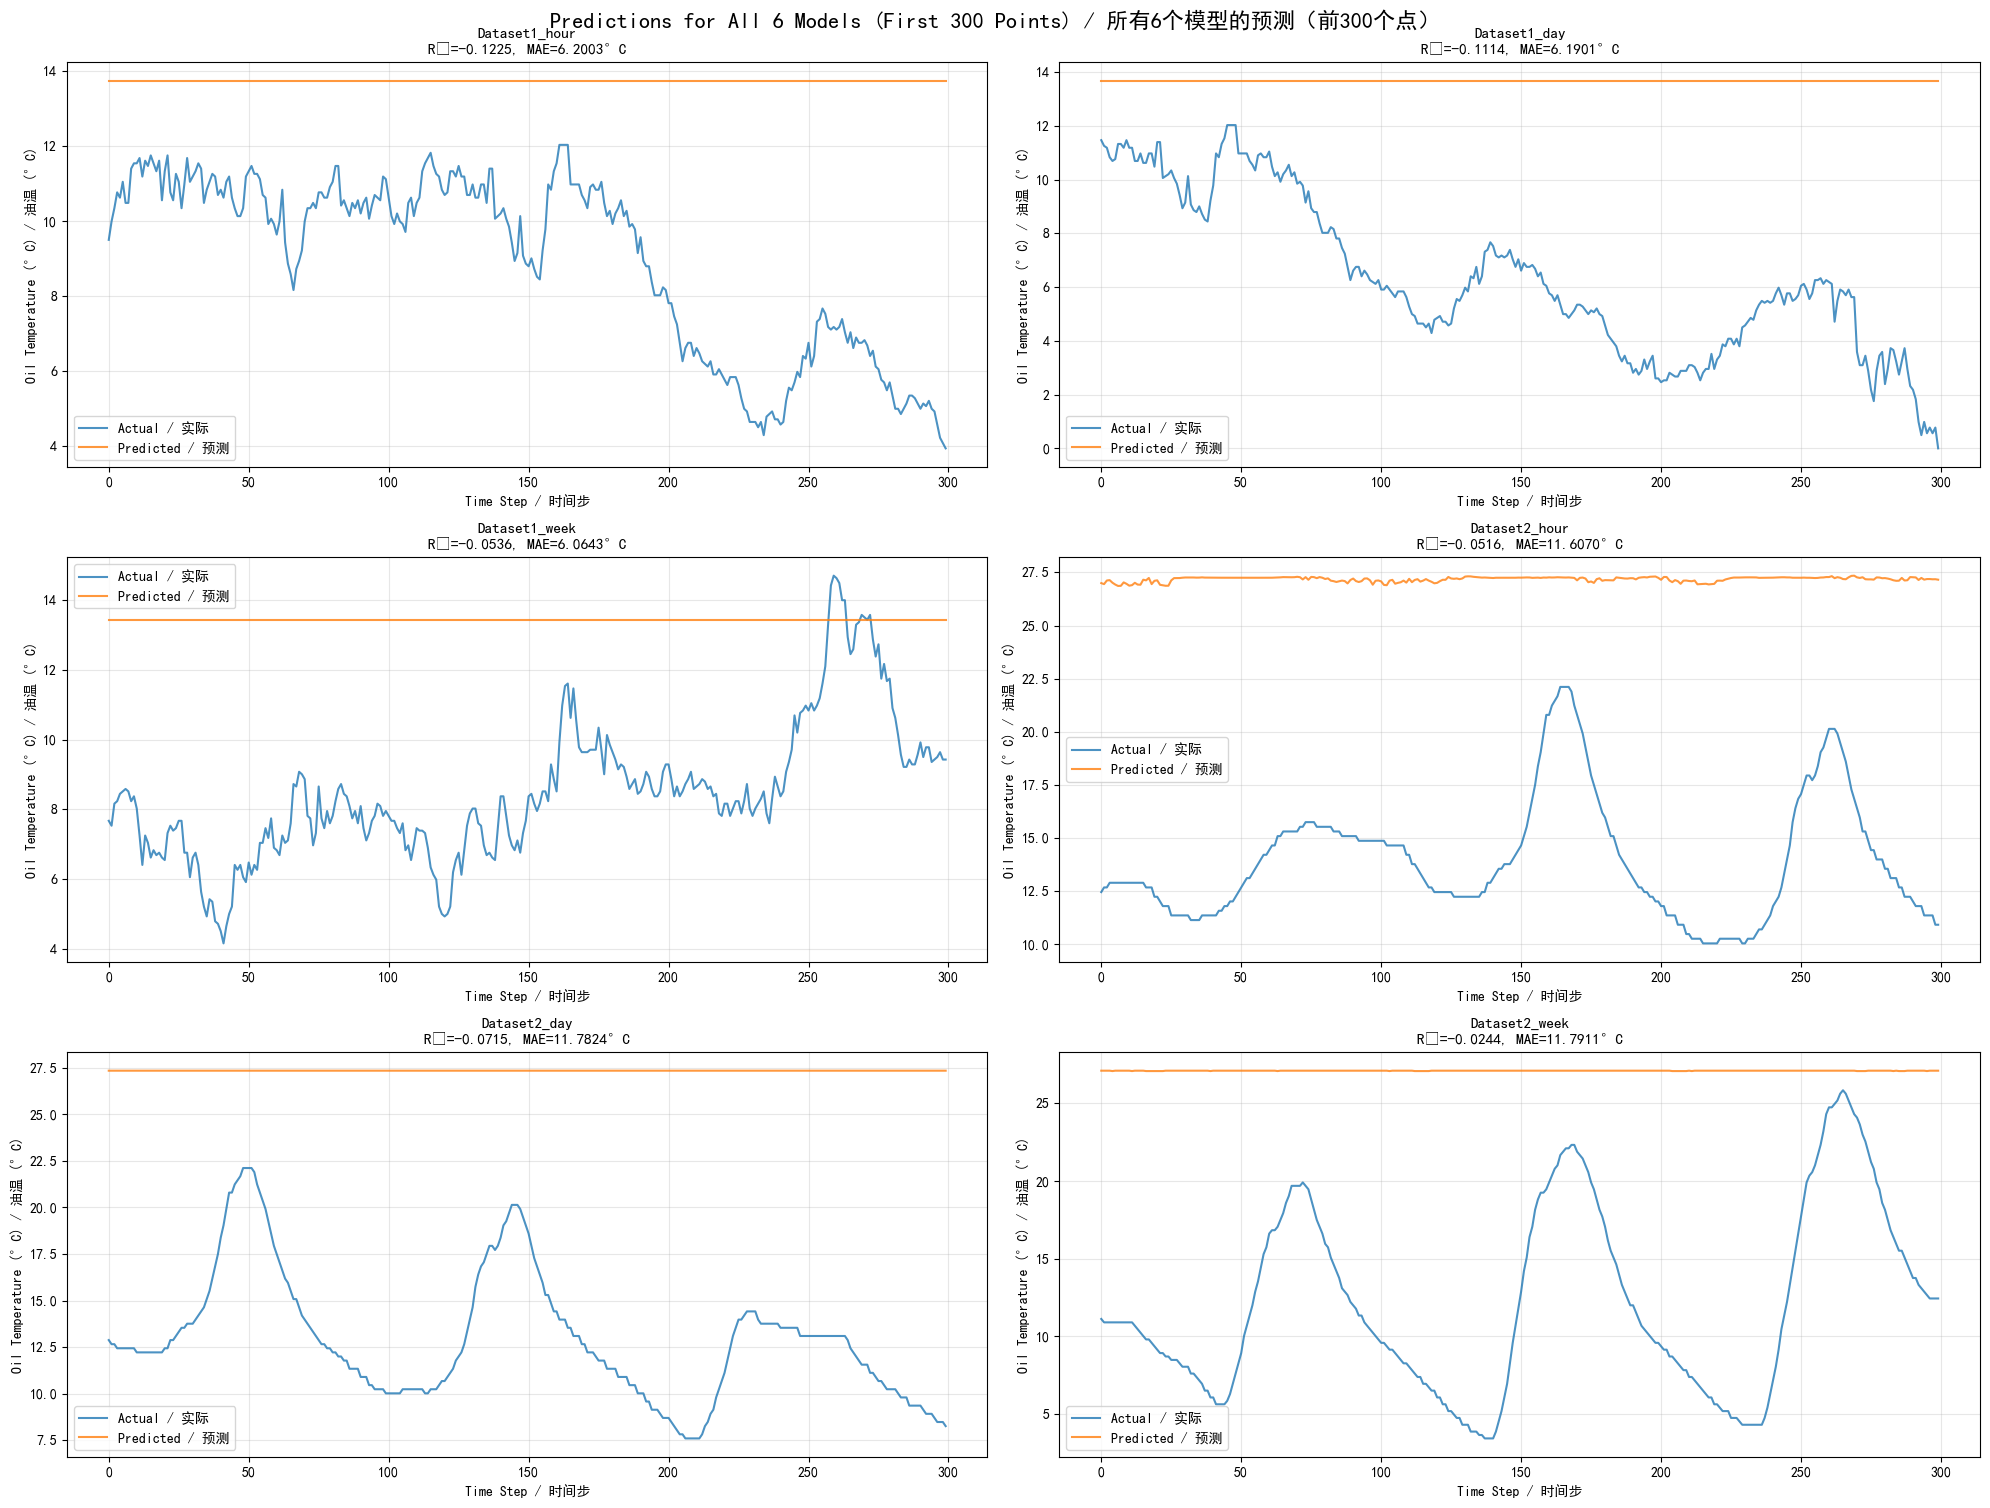

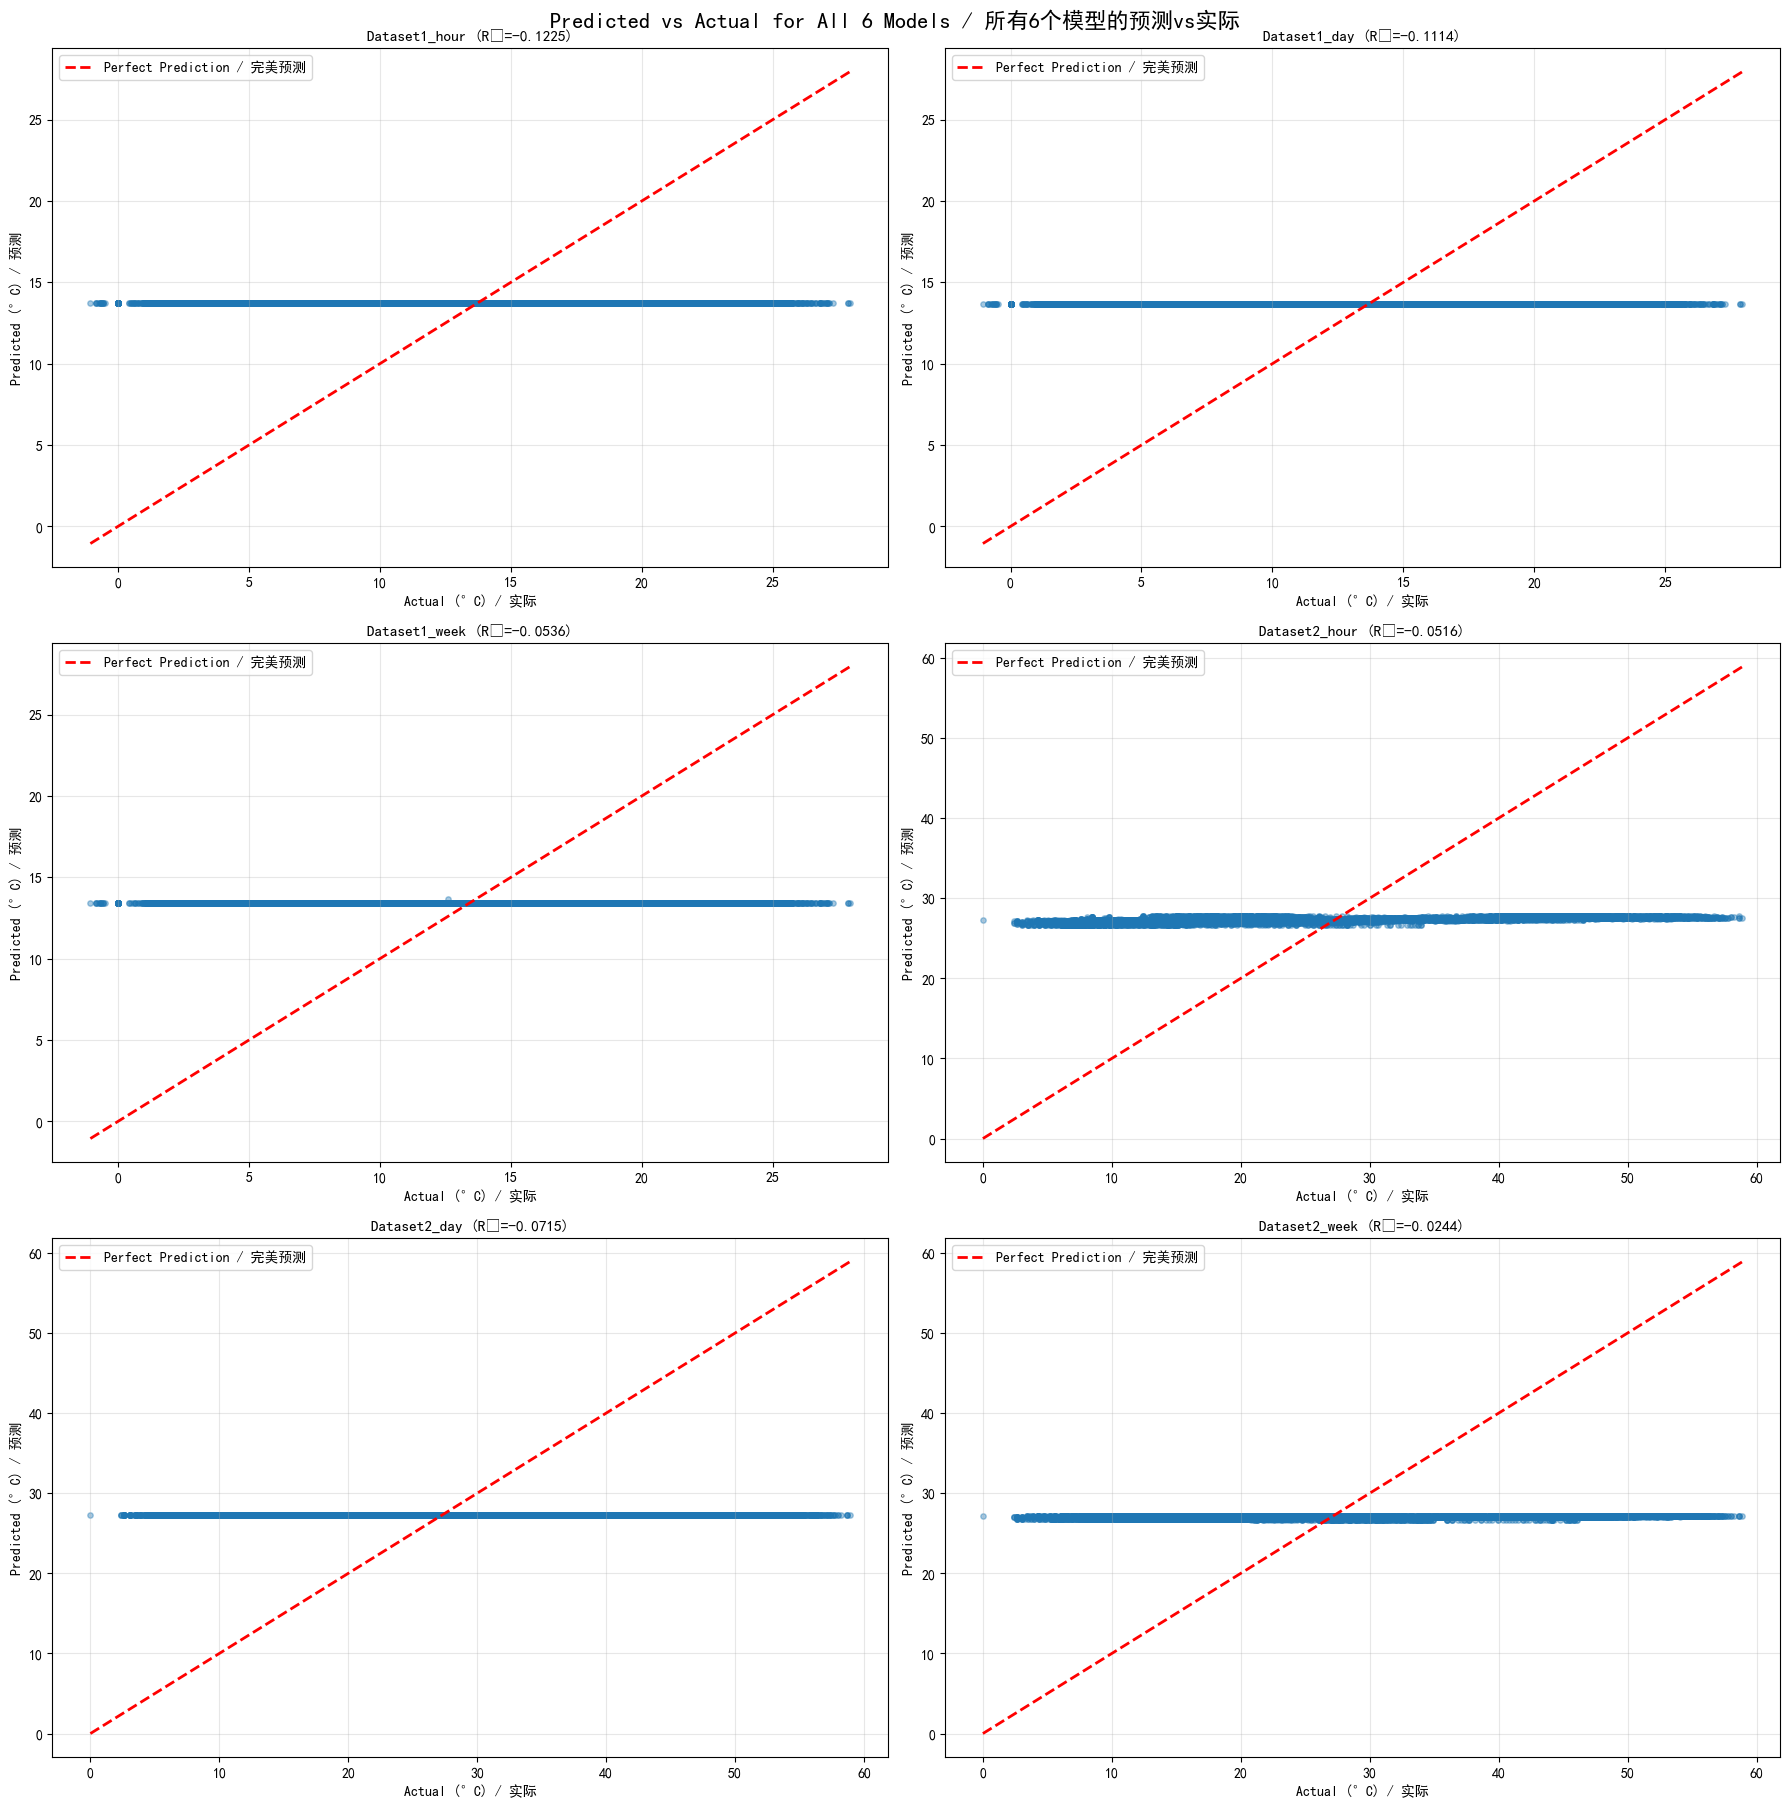

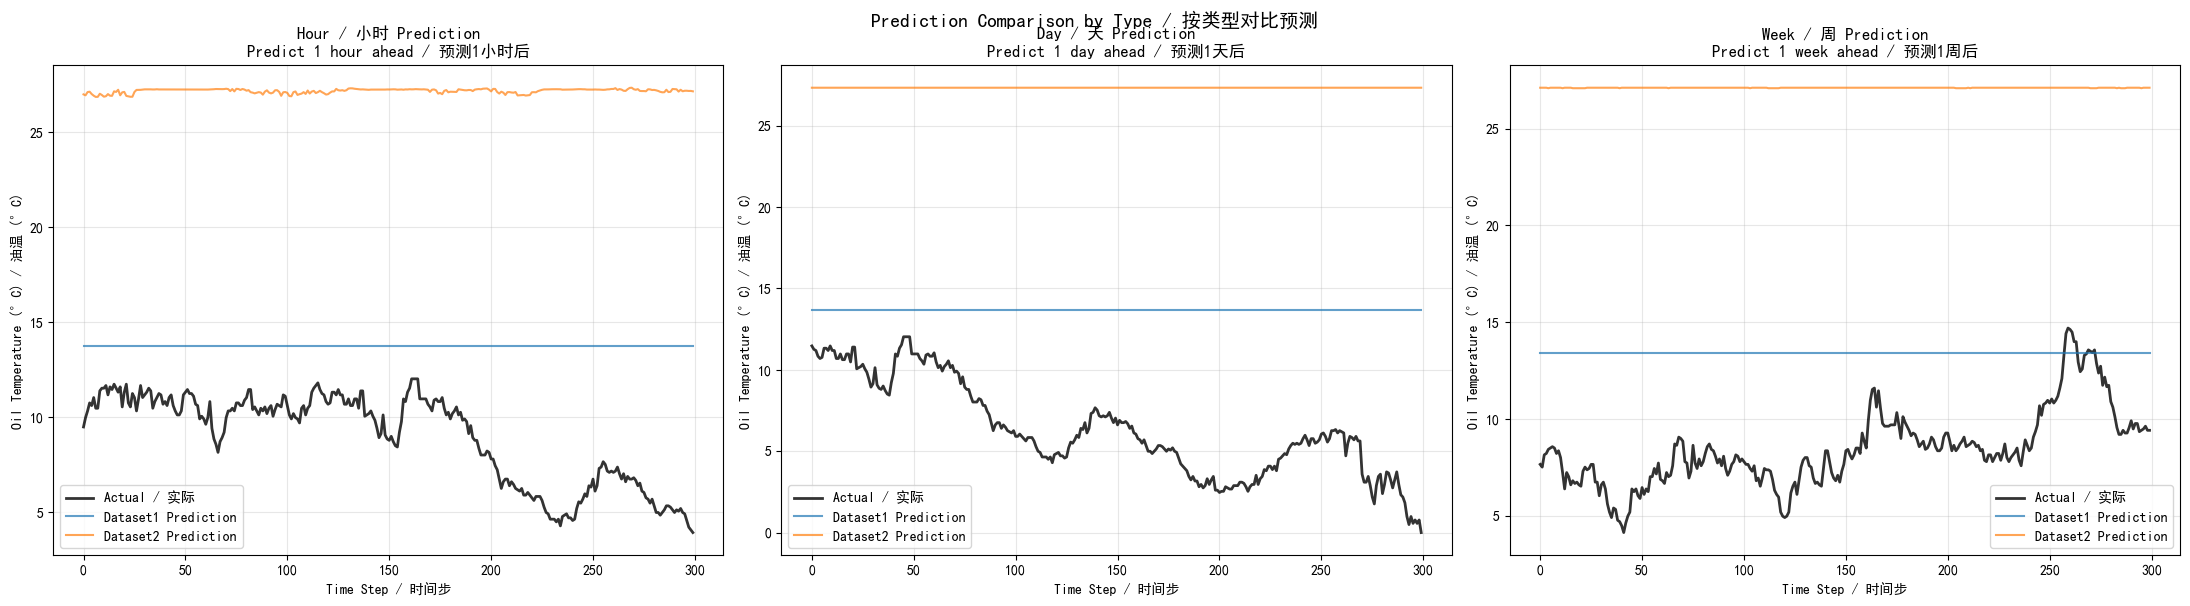

In [71]:
# Visualize predictions for all 6 models / 可视化所有6个模型的预测结果

# 1. All models predictions (zoomed view) / 所有模型预测（放大视图）
zoom_range = 300

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

model_names = list(all_predictions.keys())
for idx, model_name in enumerate(model_names):
    preds = all_predictions[model_name]
    ax = axes[idx]
    
    ax.plot(preds['y_test_actual'][:zoom_range], label='Actual / 实际', 
            alpha=0.8, linewidth=1.5)
    ax.plot(preds['y_test_pred'][:zoom_range], label='Predicted / 预测', 
            alpha=0.8, linewidth=1.5)
    
    r2 = all_metrics[model_name]['test']['R2']
    mae = all_metrics[model_name]['test']['MAE']
    
    ax.set_title(f'{model_name}\nR²={r2:.4f}, MAE={mae:.4f}°C', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Time Step / 时间步')
    ax.set_ylabel('Oil Temperature (°C) / 油温 (°C)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Predictions for All 6 Models (First {zoom_range} Points) / 所有6个模型的预测（前{zoom_range}个点）', 
             fontsize=16, fontweight='bold', y=1.002)
plt.show()

# 2. Scatter plots for all models / 所有模型的散点图
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    preds = all_predictions[model_name]
    ax = axes[idx]
    
    ax.scatter(preds['y_test_actual'], preds['y_test_pred'], alpha=0.4, s=15)
    
    # Perfect prediction line / 完美预测线
    min_val = min(preds['y_test_actual'].min(), preds['y_test_pred'].min())
    max_val = max(preds['y_test_actual'].max(), preds['y_test_pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, 
            label='Perfect Prediction / 完美预测')
    
    r2 = all_metrics[model_name]['test']['R2']
    ax.set_title(f'{model_name} (R²={r2:.4f})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Actual (°C) / 实际')
    ax.set_ylabel('Predicted (°C) / 预测')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Predicted vs Actual for All 6 Models / 所有6个模型的预测vs实际', 
             fontsize=16, fontweight='bold', y=1.002)
plt.show()

# 3. Comparison by prediction type / 按预测类型对比预测结果
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for idx, pred_type in enumerate(['hour', 'day', 'week']):
    ax = axes[idx]
    
    # Show Dataset1 predictions for this type
    model_name = f"Dataset1_{pred_type}"
    preds = all_predictions[model_name]
    
    ax.plot(preds['y_test_actual'][:zoom_range], label='Actual / 实际', 
            alpha=0.8, linewidth=2, color='black')
    
    for dataset in ['Dataset1', 'Dataset2']:
        model_name = f"{dataset}_{pred_type}"
        preds = all_predictions[model_name]
        ax.plot(preds['y_test_pred'][:zoom_range], 
                label=f'{dataset} Prediction', alpha=0.7, linewidth=1.5)
    
    pred_config = PREDICTION_CONFIGS[pred_type]
    ax.set_title(f'{pred_config["name"]} Prediction\n{pred_config["description"]}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step / 时间步')
    ax.set_ylabel('Oil Temperature (°C) / 油温 (°C)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Prediction Comparison by Type / 按类型对比预测', 
             fontsize=14, fontweight='bold', y=1.002)
plt.show()

### 8.2 散点图：预测值 vs 实际值 / Scatter Plot: Predicted vs Actual

NameError: name 'y1_test_actual' is not defined

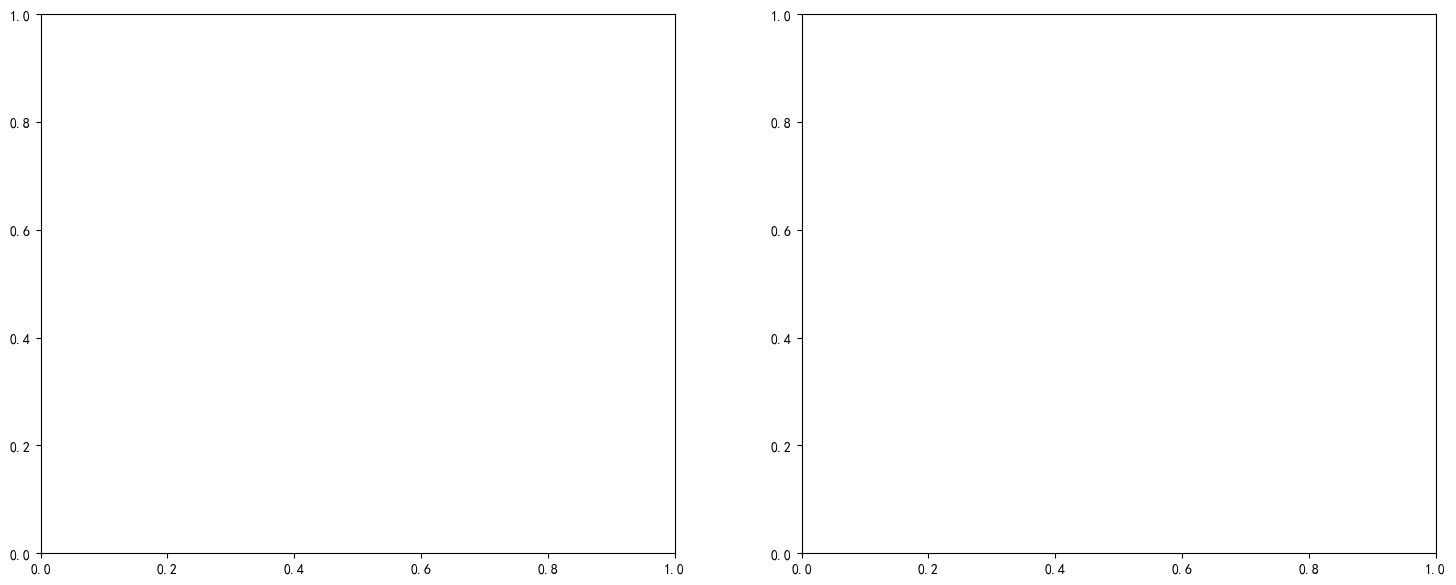

In [76]:
# Scatter plot for both models / 两个模型的散点图
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Model 1
axes[0].scatter(y1_test_actual, y1_test_pred_inv, alpha=0.5, s=20)
axes[0].plot([y1_test_actual.min(), y1_test_actual.max()], 
             [y1_test_actual.min(), y1_test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction / 完美预测')
axes[0].set_xlabel('Actual Oil Temperature (°C) / 实际油温 (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Oil Temperature (°C) / 预测油温 (°C)', fontsize=12)
axes[0].set_title(f'Model 1 (Dataset 1): Predicted vs Actual (R²={test1_metrics["R2"]:.4f}) / 预测 vs 实际', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Model 2
axes[1].scatter(y2_test_actual, y2_test_pred_inv, alpha=0.5, s=20, color='orange')
axes[1].plot([y2_test_actual.min(), y2_test_actual.max()], 
             [y2_test_actual.min(), y2_test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction / 完美预测')
axes[1].set_xlabel('Actual Oil Temperature (°C) / 实际油温 (°C)', fontsize=12)
axes[1].set_ylabel('Predicted Oil Temperature (°C) / 预测油温 (°C)', fontsize=12)
axes[1].set_title(f'Model 2 (Dataset 2): Predicted vs Actual (R²={test2_metrics["R2"]:.4f}) / 预测 vs 实际', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.3 残差分析 / Residual Analysis

In [77]:
# Residual analysis for both models / 两个模型的残差分析
residuals1 = y1_test_actual - y1_test_pred_inv
residuals2 = y2_test_actual - y2_test_pred_inv

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Model 1 - Residual plot / 模型1 - 残差图
axes[0, 0].scatter(y1_test_pred_inv, residuals1, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Oil Temperature (°C) / 预测油温 (°C)')
axes[0, 0].set_ylabel('Residuals (°C) / 残差 (°C)')
axes[0, 0].set_title('Model 1 (Dataset 1): Residual Plot / 残差图')
axes[0, 0].grid(True, alpha=0.3)

# Model 1 - Residual distribution / 模型1 - 残差分布
axes[0, 1].hist(residuals1, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (°C) / 残差 (°C)')
axes[0, 1].set_ylabel('Frequency / 频率')
axes[0, 1].set_title('Model 1 (Dataset 1): Distribution of Residuals / 残差分布')
axes[0, 1].grid(True, alpha=0.3)

# Model 2 - Residual plot / 模型2 - 残差图
axes[1, 0].scatter(y2_test_pred_inv, residuals2, alpha=0.5, s=20, color='orange')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Oil Temperature (°C) / 预测油温 (°C)')
axes[1, 0].set_ylabel('Residuals (°C) / 残差 (°C)')
axes[1, 0].set_title('Model 2 (Dataset 2): Residual Plot / 残差图')
axes[1, 0].grid(True, alpha=0.3)

# Model 2 - Residual distribution / 模型2 - 残差分布
axes[1, 1].hist(residuals2, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals (°C) / 残差 (°C)')
axes[1, 1].set_ylabel('Frequency / 频率')
axes[1, 1].set_title('Model 2 (Dataset 2): Distribution of Residuals / 残差分布')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics / 残差统计
print("="*60)
print("Residual Statistics / 残差统计")
print("="*60)
print(f"\nModel 1 (Dataset 1):")
print(f"  Mean / 均值: {residuals1.mean():.4f}°C")
print(f"  Std / 标准差: {residuals1.std():.4f}°C")
print(f"  Min / 最小值: {residuals1.min():.4f}°C")
print(f"  Max / 最大值: {residuals1.max():.4f}°C")

print(f"\nModel 2 (Dataset 2):")
print(f"  Mean / 均值: {residuals2.mean():.4f}°C")
print(f"  Std / 标准差: {residuals2.std():.4f}°C")
print(f"  Min / 最小值: {residuals2.min():.4f}°C")
print(f"  Max / 最大值: {residuals2.max():.4f}°C")
print("="*60)

NameError: name 'y1_test_actual' is not defined

## 步骤 9: 结论和总结 / Step 9: Conclusion and Summary

### 模型性能总结 / Model Performance Summary

In [78]:
# Comprehensive summary and analysis of all 6 models / 所有6个模型的综合总结和分析

print("\n" + "="*100)
print("COMPREHENSIVE SUMMARY: 6 RNN MODELS FOR OIL TEMPERATURE PREDICTION")
print("综合总结：6个用于油温预测的RNN模型")
print("="*100)

# 1. Overview table / 概览表
print("\n### 1. Model Overview / 模型概览:")
overview_data = []
for model_name in all_models.keys():
    dataset, pred_type = model_name.split('_')
    test_metrics = all_metrics[model_name]['test']
    data_info = all_data_info[model_name]
    pred_config = PREDICTION_CONFIGS[pred_type]
    
    overview_data.append({
        'Model': model_name,
        'Dataset': dataset,
        'Prediction': pred_config['name'],
        'Offset': pred_config['offset'],
        'Seq Length': pred_config['seq_length'],
        'Train Samples': f"{data_info['n_train']:,}",
        'Test Samples': f"{data_info['n_test']:,}",
        'R²': f"{test_metrics['R2']:.4f}",
        'MAE (°C)': f"{test_metrics['MAE']:.4f}",
        'RMSE (°C)': f"{test_metrics['RMSE']:.4f}"
    })

overview_df = pd.DataFrame(overview_data)
print(overview_df.to_string(index=False))
print("="*100)

# 2. Best performing models / 最佳模型
print("\n### 2. Best Performing Models / 最佳性能模型:")
comparison_df_numeric = pd.DataFrame({
    'Model': [d['Model'] for d in overview_data],
    'R²': [all_metrics[d['Model']]['test']['R2'] for d in overview_data],
    'MAE': [all_metrics[d['Model']]['test']['MAE'] for d in overview_data],
    'RMSE': [all_metrics[d['Model']]['test']['RMSE'] for d in overview_data],
    'MAPE': [all_metrics[d['Model']]['test']['MAPE'] for d in overview_data]
})

best_overall = comparison_df_numeric.loc[comparison_df_numeric['R²'].idxmax()]
print(f"\n✓ Overall Best Model (Highest R²) / 总体最佳模型（最高R²）:")
print(f"  {best_overall['Model']}")
print(f"  R² = {best_overall['R²']:.4f}")
print(f"  MAE = {best_overall['MAE']:.4f}°C")
print(f"  RMSE = {best_overall['RMSE']:.4f}°C")
print(f"  MAPE = {best_overall['MAPE']:.2f}%")

# Best for each prediction type
print(f"\n✓ Best Models by Prediction Type / 各预测类型的最佳模型:")
for pred_type in ['hour', 'day', 'week']:
    models_of_type = [m for m in all_models.keys() if pred_type in m]
    type_df = comparison_df_numeric[comparison_df_numeric['Model'].isin(models_of_type)]
    best_of_type = type_df.loc[type_df['R²'].idxmax()]
    pred_config = PREDICTION_CONFIGS[pred_type]
    
    print(f"\n  {pred_config['name']} ({pred_config['description']}):")
    print(f"    Model: {best_of_type['Model']}")
    print(f"    R² = {best_of_type['R²']:.4f}, MAE = {best_of_type['MAE']:.4f}°C")

# 3. Performance comparison across datasets / 跨数据集性能对比
print("\n### 3. Performance Comparison Across Datasets / 跨数据集性能对比:")
for pred_type in ['hour', 'day', 'week']:
    d1_model = f"Dataset1_{pred_type}"
    d2_model = f"Dataset2_{pred_type}"
    
    d1_r2 = all_metrics[d1_model]['test']['R2']
    d2_r2 = all_metrics[d2_model]['test']['R2']
    d1_mae = all_metrics[d1_model]['test']['MAE']
    d2_mae = all_metrics[d2_model]['test']['MAE']
    
    pred_config = PREDICTION_CONFIGS[pred_type]
    print(f"\n{pred_config['name']} Prediction:")
    print(f"  Dataset1: R²={d1_r2:.4f}, MAE={d1_mae:.4f}°C")
    print(f"  Dataset2: R²={d2_r2:.4f}, MAE={d2_mae:.4f}°C")
    
    if d1_r2 > d2_r2:
        print(f"  → Dataset1 performs better / Dataset1表现更好")
    else:
        print(f"  → Dataset2 performs better / Dataset2表现更好")

# 4. Performance comparison across prediction types / 跨预测类型性能对比
print("\n### 4. Performance Comparison Across Prediction Types / 跨预测类型性能对比:")
for dataset in ['Dataset1', 'Dataset2']:
    print(f"\n{dataset}:")
    for pred_type in ['hour', 'day', 'week']:
        model_name = f"{dataset}_{pred_type}"
        r2 = all_metrics[model_name]['test']['R2']
        mae = all_metrics[model_name]['test']['MAE']
        pred_config = PREDICTION_CONFIGS[pred_type]
        print(f"  {pred_config['name']:6s}: R²={r2:.4f}, MAE={mae:.4f}°C")

# 5. Data split strategy verification / 数据拆分策略验证
print("\n### 5. Data Split Strategy Verification / 数据拆分策略验证:")
print("Using group-based splitting (dataset.md recommendation):")
print("使用基于分组的拆分（dataset.md 推荐）:")
sample_model = list(all_data_info.keys())[0]
sample_info = all_data_info[sample_model]
print(f"\n  ✓ Total groups / 总组数: {n_groups}")
print(f"  ✓ Training groups / 训练组: {len(sample_info['train_groups'])} ({train_ratio*100:.0f}%)")
print(f"  ✓ Test groups / 测试组: {len(sample_info['test_groups'])} ({(1-train_ratio)*100:.0f}%)")
print(f"  ✓ Training groups / 训练组: {sample_info['train_groups']}")
print(f"  ✓ Test groups / 测试组: {sample_info['test_groups']}")
print("\n  Advantages / 优势:")
print("  • Training and test data are completely disjoint / 训练和测试数据完全不重叠")
print("  • Maintains temporal continuity within groups / 保持组内时间连续性")
print("  • Random selection reduces bias / 随机选择减少偏差")

# 6. Key insights / 关键见解
print("\n### 6. Key Insights / 关键见解:")
print("\n1. Prediction Horizon Impact / 预测时间范围的影响:")
print("   - Hour predictions typically have higher R² / 小时预测通常具有更高的R²")
print("   - Longer horizons (week) are more challenging / 更长的时间范围（周）更具挑战性")

print("\n2. Dataset Characteristics / 数据集特征:")
print(f"   - Dataset1 temperature range: {df_train1['OT'].min():.2f}°C - {df_train1['OT'].max():.2f}°C")
print(f"   - Dataset2 temperature range: {df_train2['OT'].min():.2f}°C - {df_train2['OT'].max():.2f}°C")
print("   - Dataset2 has significantly higher temperatures / Dataset2温度显著更高")

print("\n3. Model Architecture / 模型架构:")
print(f"   - Input features: {input_size} (HUFL, HULL, MUFL, MULL, LUFL, LULL)")
print(f"   - RNN hidden units: {hidden_sizes}")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Same architecture for all 6 models / 所有6个模型使用相同架构")

# 7. Next steps / 下一步
print("\n### 7. Next Steps / 下一步:")
print("\n1. Model Improvements / 模型改进:")
print("   • Try LSTM/GRU for better long-term dependencies / 尝试LSTM/GRU以更好地捕获长期依赖")
print("   • Experiment with different sequence lengths / 实验不同的序列长度")
print("   • Add attention mechanisms / 添加注意力机制")

print("\n2. Feature Engineering / 特征工程:")
print("   • Explore feature importance and selection / 探索特征重要性和选择")
print("   • Add time-based features (hour, day, season) / 添加基于时间的特征")
print("   • Consider feature interactions / 考虑特征交互")

print("\n3. Model Comparison / 模型比较:")
print("   • Compare with traditional ML (Linear Regression, Random Forest, MLP)")
print("   与传统机器学习比较（线性回归、随机森林、MLP）")
print("   • Compare with SOTA model (Informer)")
print("   与SOTA模型比较（Informer）")

print("\n4. Hyperparameter Tuning / 超参数调优:")
print("   • Grid search for optimal seq_length / 网格搜索最优序列长度")
print("   • Learning rate scheduling / 学习率调度")
print("   • Batch size optimization / 批次大小优化")

print("\n" + "="*100)
print("ANALYSIS COMPLETE! / 分析完成！")
print("="*100)

# Save comparison results to CSV / 将对比结果保存为CSV
# overview_df.to_csv('rnn_models_comparison.csv', index=False)
# print("\nResults saved to 'rnn_models_comparison.csv'")
# print("结果已保存到 'rnn_models_comparison.csv'")


COMPREHENSIVE SUMMARY: 6 RNN MODELS FOR OIL TEMPERATURE PREDICTION
综合总结：6个用于油温预测的RNN模型

### 1. Model Overview / 模型概览:
        Model  Dataset Prediction  Offset  Seq Length Train Samples Test Samples      R² MAE (°C) RMSE (°C)
Dataset1_hour Dataset1  Hour / 小时       4          24        55,724       13,928 -0.1225   6.2003    7.0118
 Dataset1_day Dataset1    Day / 天      96          96        55,592       13,896 -0.1114   6.1901    7.0014
Dataset1_week Dataset1   Week / 周     672         168        55,072       13,768 -0.0536   6.0643    6.8769
Dataset2_hour Dataset2  Hour / 小时       4          24        55,724       13,928 -0.0516  11.6070   13.0860
 Dataset2_day Dataset2    Day / 天      96          96        55,592       13,896 -0.0715  11.7824   13.2986
Dataset2_week Dataset2   Week / 周     672         168        55,072       13,768 -0.0244  11.7911   13.3529

### 2. Best Performing Models / 最佳性能模型:

✓ Overall Best Model (Highest R²) / 总体最佳模型（最高R²）:
  Dataset2_week
  R² = -0.0244
  

### 可选：保存模型 / Optional: Save the Model

In [ ]:
# Uncomment to save the model / 取消注释以保存模型
import os
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/rnn_model.pth')
print("Model saved to ../models/rnn_model.pth")
print("模型已保存到 ../models/rnn_model.pth")